The goal of this notebook is to analyze the difference between air temperature via satellital images and in-situ measuring devices

In [1]:
from functions import *

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point,box
import requests
from scipy.stats import ks_2samp
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import datetime
from collections import Counter
import matplotlib.patches as patches
import seaborn as sns

#### Load data

In [3]:
def load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths=['lst', 'slope', 'discharge', 'ndvi', 'altitude'],
    filter_altitude=None,
    W=256,
    time_split=False,
):
    
    dir_paths = [os.path.join(source_path, p) for p in data_paths]
    
    all_dir_paths = {k: [] for k in data_paths}
    total_data = {}
    total_times = {}

    if not filter_altitude:
        rivers = [f.split('station_')[-1].split('.')[0] for f in os.listdir(source_folder) if os.path.join(source_folder, f).endswith('shp')]
    else:
        rivers = get_rivers_altitude(source_folder)
    
    # Cargar rutas de entrada
    for i, dir_p in enumerate(dir_paths):
        for subdir, dirs, files in os.walk(dir_p):
            if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints') and subdir.split('/')[-1] in rivers:
                all_dir_paths[data_paths[i]].append(subdir) if not dir_p.endswith('altitude') else all_dir_paths[data_paths[i]].extend(files)
    
    # Cargar datos de entrada
    for k, v in all_dir_paths.items():
        labels = []
        if k not in ['discharge', 'slope', 'altitude']:
            list_rgb = [True] * len(v) if k in ['lst', 'masked'] else [False] * len(v)
            data, times = load_data(v, W, list_rgb)
            if k != 'masked':
                for ki in data.keys():
                    labels += [ki.split('/')[-1]] * len(data[ki])

            data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
            times_list = [t for sublist in times for t in sublist]

            if time_split:
                dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
                pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
                sorted_dates, data_values, labels = zip(*pairs)
                times_list = [date.strftime('%Y-%m') for date in sorted_dates]

            total_data[k] = np.array(data_values)
            total_times[k] = times_list
            print(f"{k} : {total_data[k].shape}")

    # Cargar variables adicionales
    for k, v in all_dir_paths.items():
        if k in ['discharge', 'slope', 'altitude']:
            imgss = {}
            total = []
            for i, lab in enumerate(labels):
                for file in v:
                    if lab in file.split('/')[-1] or lab in file.split('.')[0]:
                        if lab not in imgss:
                            file_path = os.path.join(file, os.listdir(file)[0]) if k != 'altitude' else os.path.join('../data/preprocessed/altitude', file)
                            r, m = load_raster(file_path, False)
                            var = resize_image(r, W, W)
                            var = np.where(np.isnan(var), 0.0, var)
                            imgss[lab] = var
                        total.append(imgss[lab])

            total_data[k] = np.array(total)
            print(f"{k}: {np.array(total).shape}")

    # Cargar variable objetivo
    water_temp = pd.read_csv('../data/preprocessed/wt/water_temp.csv', index_col=0)
    times_ordered = total_times['lst']
    wt_temp = []
    for cell, date in zip(labels, times_ordered):
        temp = water_temp[(water_temp["Cell"] == cell) & (water_temp["Date"] == date)]["WaterTemp"]
        if not temp.empty:
            wt_temp.append(temp.values[0])
    data_targets = np.array(wt_temp)

    return total_data, total_times, data_targets, labels

In [ ]:
W=64
inputs = ['lst','ndvi']#, 'discharge','altitude']
split = 'random'

if W==128:
    data_folder = '../data/preprocessed/'
else:
    data_folder = '../data/preprocessed/64x64/'

data = load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path=data_folder,
    data_paths= inputs,
    filter_altitude=False,
    W=W,
    time_split=True if split=='time' else False)

lst : (1628, 64, 64, 3)


#### Load rivers

In [ ]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass

## Data stats

In [ ]:
total_data, total_times, data_targets, labels = data

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Sample data (simulated) since real data wasn't provided
data = {
    "label": labels[0:len(total_times['lst'])],
    "fecha": total_times['lst']
}
df = pd.DataFrame(data)
df['cell_num'] = df['label'].apply(lambda x: int(re.search(r'\d+', x).group()))

def categorize_season(date_str):
    month = int(date_str.split("-")[1])  # Extract month as integer
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Spring-Autumn"

# Apply season categorization
df['season'] = df['fecha'].apply(categorize_season)

# Count frequency of labels and seasons
label_counts = df['label'].value_counts()
season_counts = df['season'].value_counts()

# Calculate top 20 most frequent cell numbers
cell_counts = df['cell_num'].value_counts().head(20)

# Plot for top 20 cell numbers
plt.figure(figsize=(10, 6))
cell_counts.plot(kind='bar', color="skyblue", edgecolor="black")
plt.title("Top 20 Cell Frequency")
plt.xlabel("Cell Numbers", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../plots/top_20_cell_frequency_low_alt.png")  # Save as PNG
plt.close()  # Close the plot to avoid overlap

# Plot for season frequency
plt.figure(figsize=(6, 6))
season_counts.plot(kind='bar', color="salmon", edgecolor="black")
plt.title("Frequency by Season")
plt.xlabel("Seasons", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../plots/season_frequency_low_alt.png")  # Save as PNG
plt.close()  # Close the plot


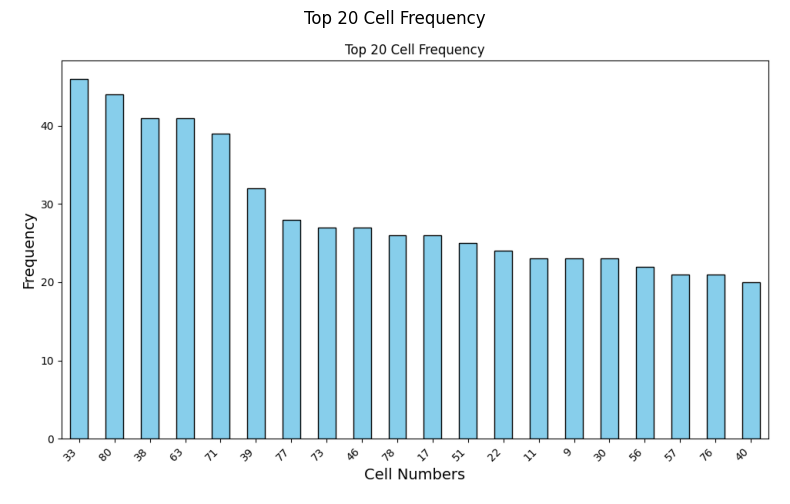

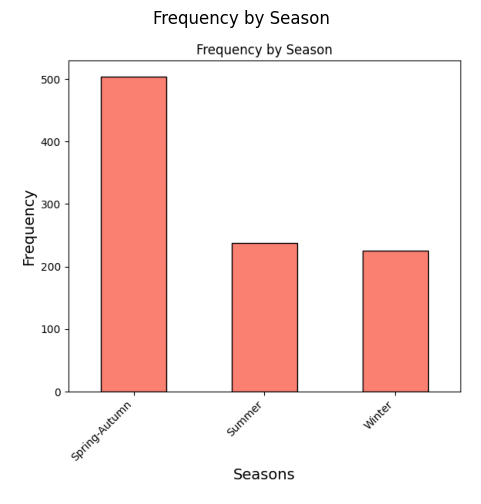

In [63]:
img1 = plt.imread("../plots/top_20_cell_frequency_low_alt.png")
plt.figure(figsize=(10, 6))
plt.imshow(img1)
plt.axis('off')  # Hide axis for a cleaner look
plt.title("Top 20 Cell Frequency")
plt.show()

# Load and display the season frequency chart
img2 = plt.imread("../plots/season_frequency_low_alt.png")
plt.figure(figsize=(6, 6))
plt.imshow(img2)
plt.axis('off')  # Hide axis for a cleaner look
plt.title("Frequency by Season")
plt.show()

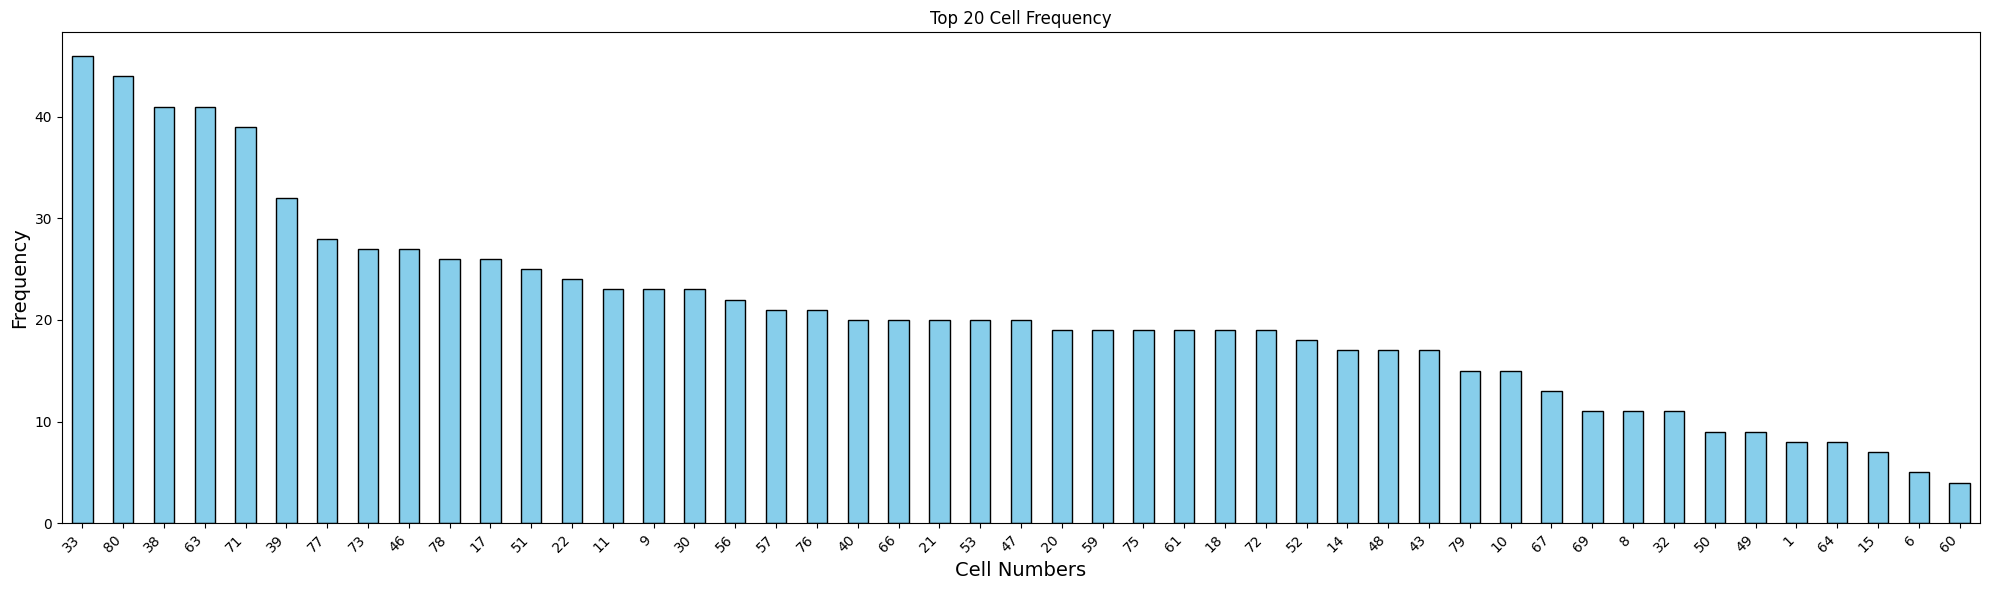

In [64]:
cell_counts = df['cell_num'].value_counts()

# Plot for top 20 cell numbers
plt.figure(figsize=(20, 6))
cell_counts.plot(kind='bar', color="skyblue", edgecolor="black")
plt.title("Top 20 Cell Frequency")
plt.xlabel("Cell Numbers", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


#### Frequency heatmap

In [ ]:
def get_lat_lon(labels):
    file_path = '../data/raw/wt/cell_coordinates_oficial.csv'
    lat_lon = pd.read_csv(file_path)
    lats=[]
    lons=[]
    for label in labels:
        num_cell = int(label.split('_')[-1])
        lat = lat_lon[lat_lon.Cell==num_cell].Latitude.values[0]
        lon = lat_lon[lat_lon.Cell==num_cell].Longitude.values[0]
        lats.append(lat)
        lons.append(lon)
    lats = np.array(lats)
    lons = np.array(lons)
    return lats, lons

In [17]:
len(labels)

1628

In [ ]:
lat, lon = get_lat_lon(labels)
merged_df = pd.DataFrame(data={'lat':list(lat),'lon':list(lon),'labels':labels})
merged_df

In [18]:
frequency_df = merged_df.groupby(['lat', 'lon']).size().reset_index(name='frequency')

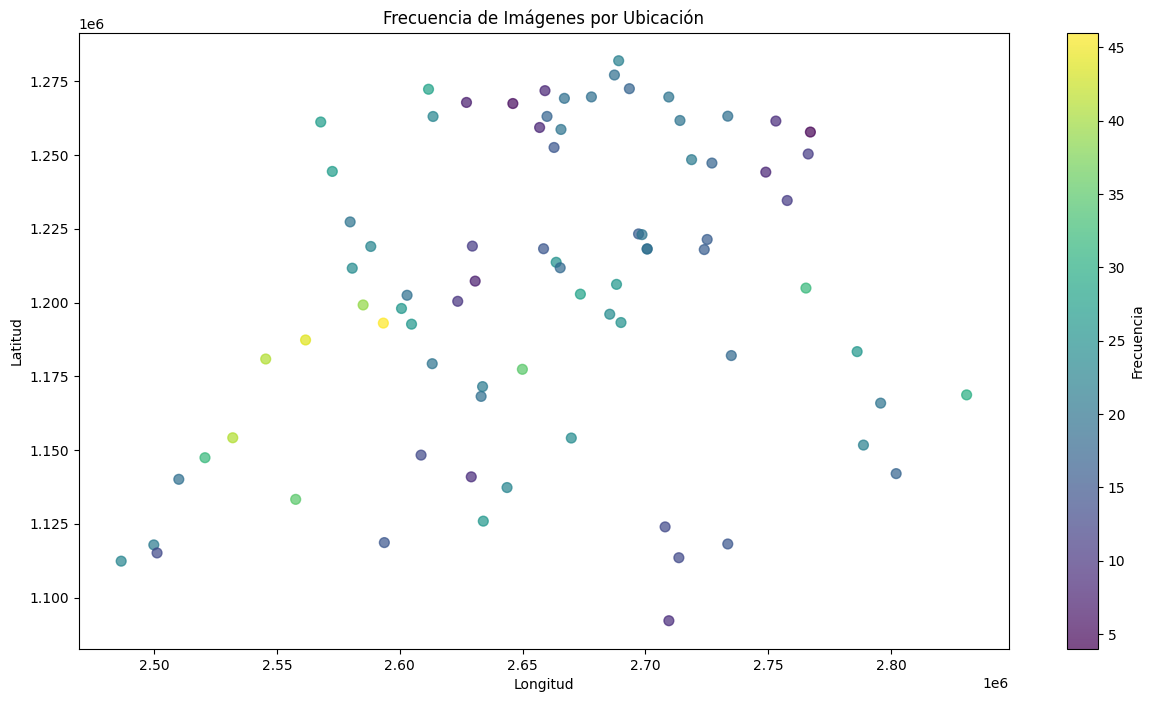

In [34]:
plt.figure(figsize=(15, 8))
plt.scatter(frequency_df['lat'], frequency_df['lon'], c=frequency_df['frequency'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label="Frecuencia")
plt.title("Frecuencia de Imágenes por Ubicación")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Create the GeoDataFrame in EPSG:2056
gdf = gpd.GeoDataFrame(
    frequency_df, 
    geometry=gpd.points_from_xy(frequency_df.lat, frequency_df.lon), 
    crs="EPSG:2056"
)

# Convert to EPSG:4326 to use with contextily
gdf = gdf.to_crs(epsg=2056)

# Define an appropriate zoom level (e.g., zoom=12 or zoom=13 for regional detail)
zoom_level = 12

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    ax=ax,
    column='frequency',       # Use 'frequency' column for color mapping
    cmap='viridis',           # Color map for frequencies
    markersize=gdf['frequency'] * 5,  # Adjust marker size based on frequency
    legend=True,
    alpha=0.7
)

# Add the basemap with a fixed zoom level
ctx.add_basemap(ax, crs="EPSG:2056", source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom_level)

# Add title and labels
ax.set_title("Image Frequency on Switzerland Basemap")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


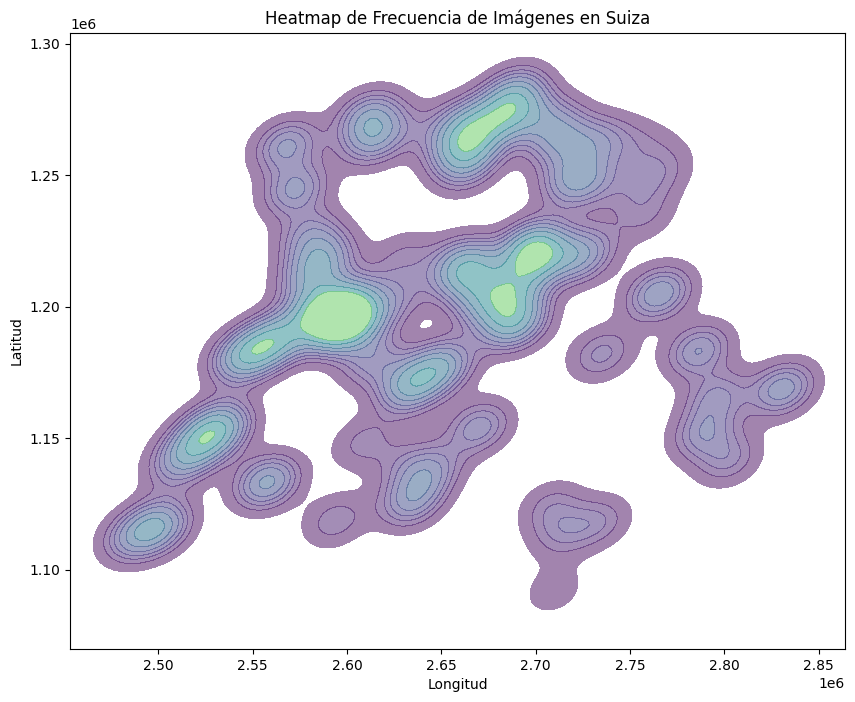

In [35]:
plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=frequency_df,
    x='lat',
    y='lon',
    weights='frequency',
    cmap='viridis',
    fill=True,
    alpha=0.5,
    bw_adjust=0.3  # Reduce el bandwidth para mayor detalle
)
plt.title("Heatmap de Frecuencia de Imágenes en Suiza")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


### Water temperature evolution

In [65]:
len(data_targets)

968

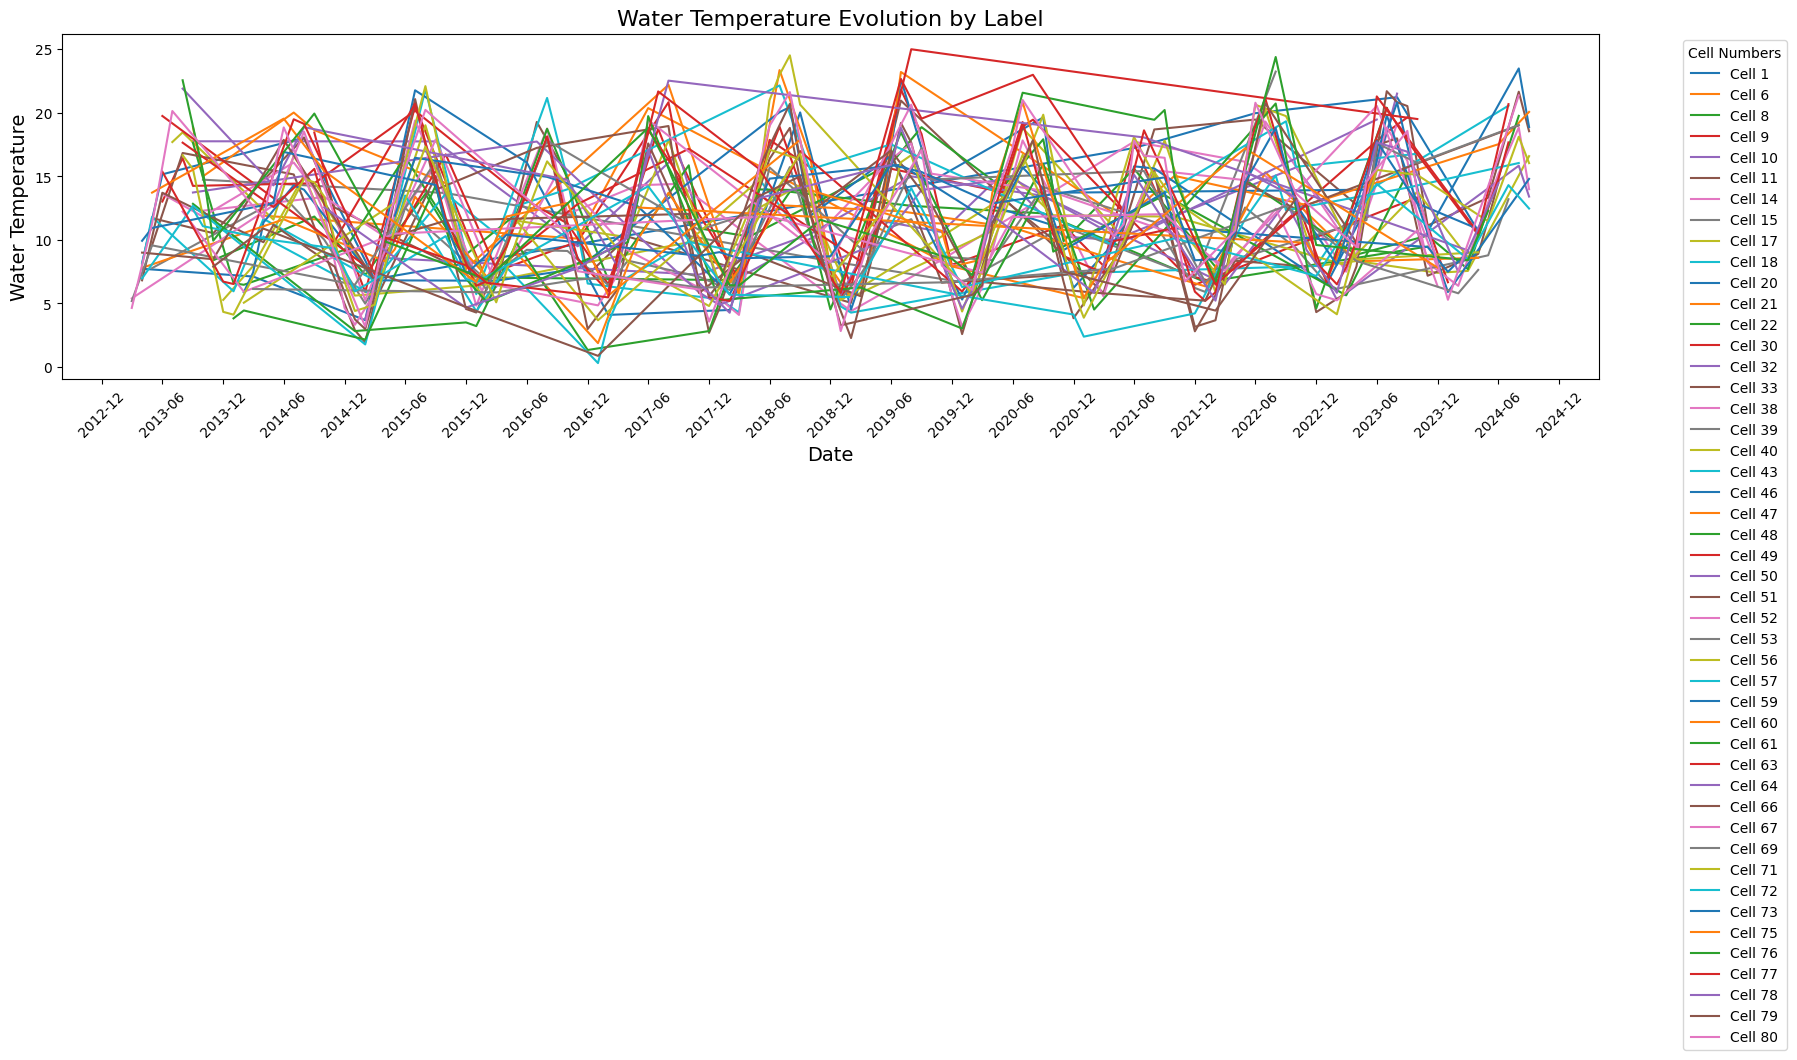

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import matplotlib.dates as mdates

# Assuming your data includes temperature information alongside labels and dates
data = {
    "label": labels[0:len(total_times['lst'])],
    "fecha": total_times['lst'],
    "temperature": data_targets  # Add your list of water temperatures here
}
df = pd.DataFrame(data)
df['cell_num'] = df['label'].apply(lambda x: int(re.search(r'\d+', x).group()))

# Convert 'fecha' to datetime format
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m")

# Sort by label and date for proper plotting
df = df.sort_values(by=['cell_num', 'fecha'])

# Set the figure size to make the x-axis wider
plt.figure(figsize=(18, 8))

# Plot temperature evolution by label without resampling or interpolation
for cell_num, group in df.groupby('cell_num'):
    plt.plot(group['fecha'], group['temperature'], label=f'Cell {cell_num}')

# Set axis labels and title
plt.xlabel("Date", fontsize=18)
plt.ylabel("Water Temperature", fontsize=18)
plt.title("Water Temperature Evolution by Label", fontsize=16)

# Rotate x-axis labels to make dates readable
plt.xticks(rotation=45)

# Set x-axis to display dates every 6 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Place the legend outside the plot for clarity
plt.legend(title="Cell Numbers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### LST evolution

In [43]:
lst_folder = '../data/preprocessed/ndvi'
W=128
cells_data={}
cells_times = {}
imgs_paths = [os.path.join(lst_folder,file) for file in os.listdir(lst_folder)]
list_rgb = [False] * len(imgs_paths)
data, times = load_data(imgs_paths, W, list_rgb)

In [5]:
len(data['../data/preprocessed/lst/cell_67'])

13

In [6]:
data.keys()

dict_keys(['../data/preprocessed/lst/cell_67', '../data/preprocessed/lst/cell_2', '../data/preprocessed/lst/cell_70', '../data/preprocessed/lst/cell_31', '../data/preprocessed/lst/cell_19', '../data/preprocessed/lst/cell_29', '../data/preprocessed/lst/cell_71', '../data/preprocessed/lst/cell_49', '../data/preprocessed/lst/cell_43', '../data/preprocessed/lst/cell_10', '../data/preprocessed/lst/cell_13', '../data/preprocessed/lst/cell_41', '../data/preprocessed/lst/cell_21', '../data/preprocessed/lst/cell_11', '../data/preprocessed/lst/cell_58', '../data/preprocessed/lst/cell_56', '../data/preprocessed/lst/cell_74', '../data/preprocessed/lst/cell_37', '../data/preprocessed/lst/cell_62', '../data/preprocessed/lst/cell_72', '../data/preprocessed/lst/cell_65', '../data/preprocessed/lst/cell_8', '../data/preprocessed/lst/cell_80', '../data/preprocessed/lst/cell_68', '../data/preprocessed/lst/cell_9', '../data/preprocessed/lst/cell_18', '../data/preprocessed/lst/cell_69', '../data/preprocesse

['2013-08', '2014-02', '2015-05', '2018-06', '2020-03', '2020-06', '2021-09', '2022-03', '2022-08', '2022-12', '2023-02', '2023-10', '2023-12']


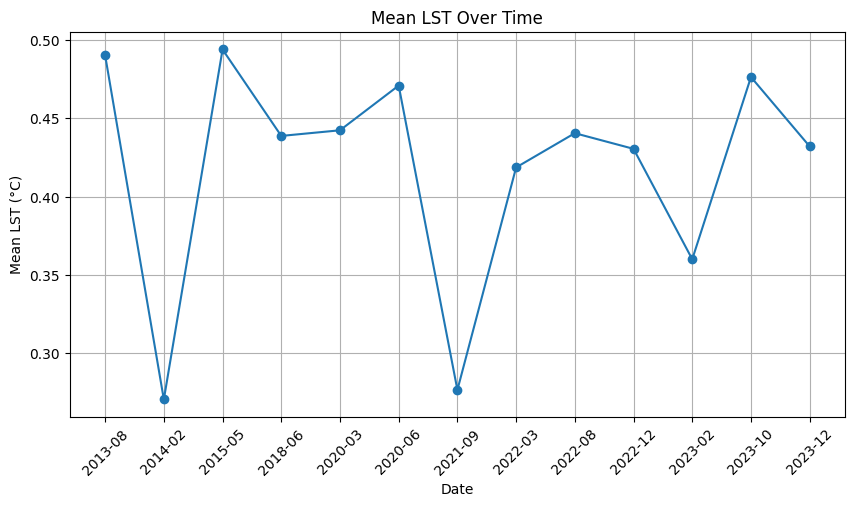

['2013-07', '2014-01', '2015-07', '2015-12', '2016-08', '2018-04', '2019-02', '2019-06', '2021-02', '2022-04', '2022-05', '2022-11', '2024-01', '2024-02', '2024-06']


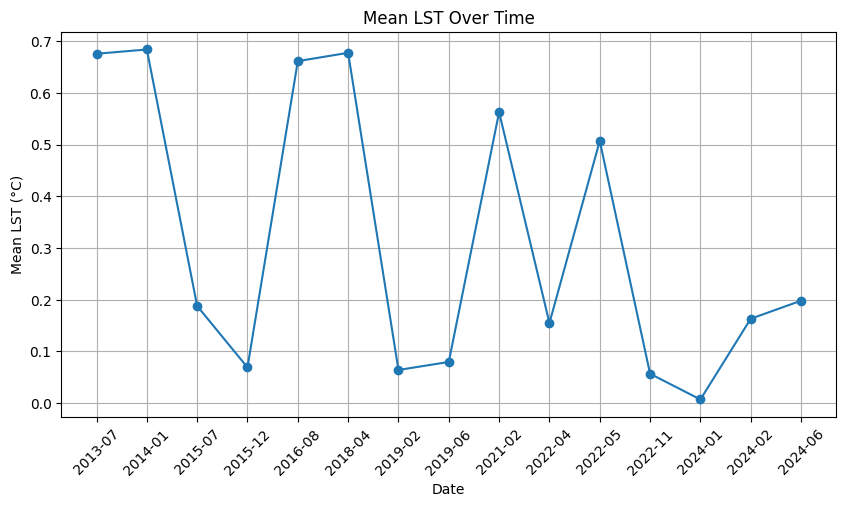

['2013-12', '2014-06', '2015-05', '2015-06', '2016-06', '2017-01', '2017-08', '2017-09', '2017-11', '2017-12', '2018-01', '2018-08', '2018-12', '2019-01', '2019-03', '2019-07', '2020-03', '2020-07', '2020-10', '2021-01', '2021-08', '2021-12', '2022-09', '2022-12', '2023-01', '2023-02', '2023-04', '2023-05', '2023-12', '2024-01', '2024-08', '2024-09']


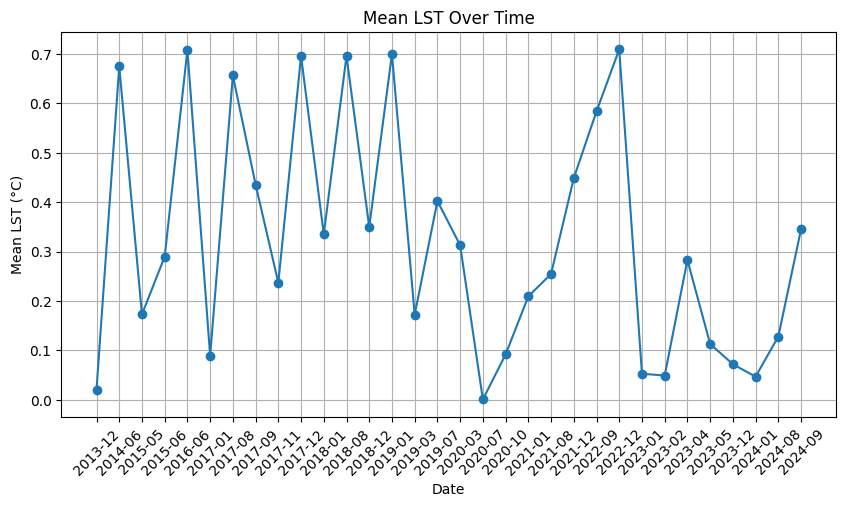

['2013-07', '2014-01', '2014-02', '2016-08', '2016-10', '2017-02', '2019-01', '2019-04', '2019-08', '2020-01', '2022-01', '2022-11', '2022-12', '2023-05', '2023-07', '2023-09', '2023-10', '2024-06', '2024-08']


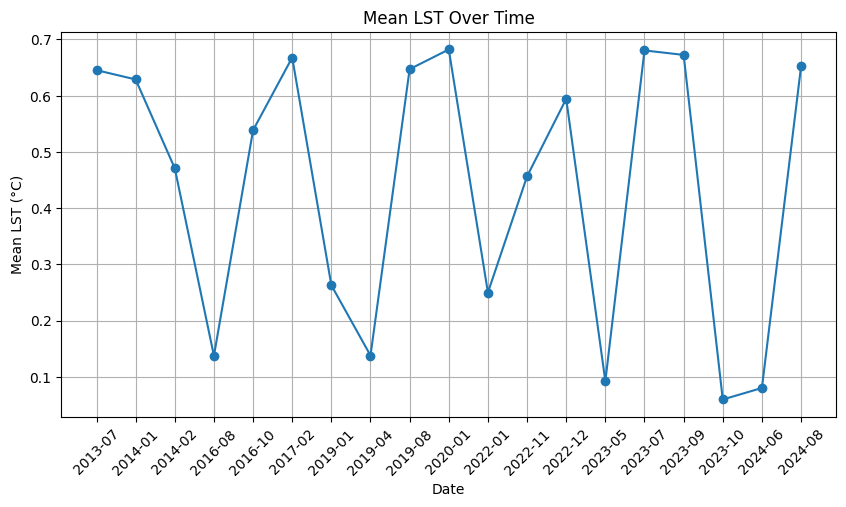

['2014-04', '2015-08', '2015-11', '2015-12', '2016-05', '2016-07', '2017-04', '2017-07', '2018-01', '2018-08', '2018-11', '2019-04', '2019-06', '2019-08', '2019-09', '2019-12', '2020-06', '2020-12', '2022-10', '2023-07', '2023-12', '2024-01', '2024-02', '2024-07']


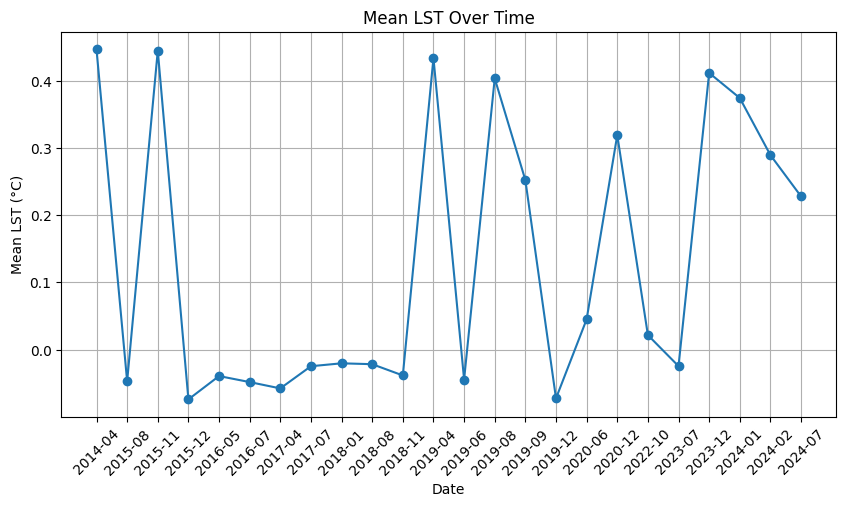

['2013-08', '2013-09', '2013-12', '2014-01', '2014-08', '2014-09', '2014-10', '2014-12', '2015-01', '2015-03', '2015-05', '2015-08', '2016-03', '2016-05', '2016-07', '2016-08', '2017-04', '2017-12', '2018-05', '2018-09', '2018-11', '2018-12', '2019-06', '2019-07', '2019-08', '2020-01', '2020-07', '2020-11', '2020-12', '2021-01', '2021-05', '2021-08', '2021-10', '2023-02', '2023-06', '2023-10', '2024-05', '2024-08', '2024-09']


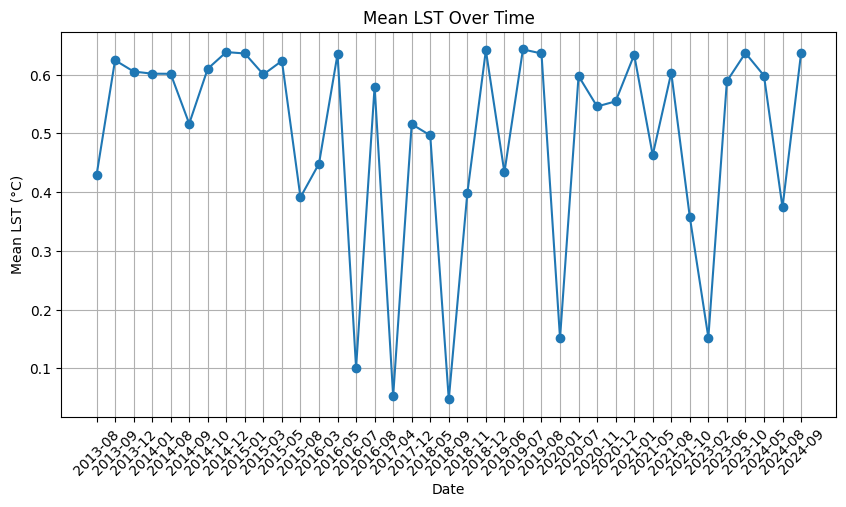

['2013-06', '2015-03', '2015-10', '2016-03', '2016-11', '2017-10', '2019-03', '2019-08', '2023-10']


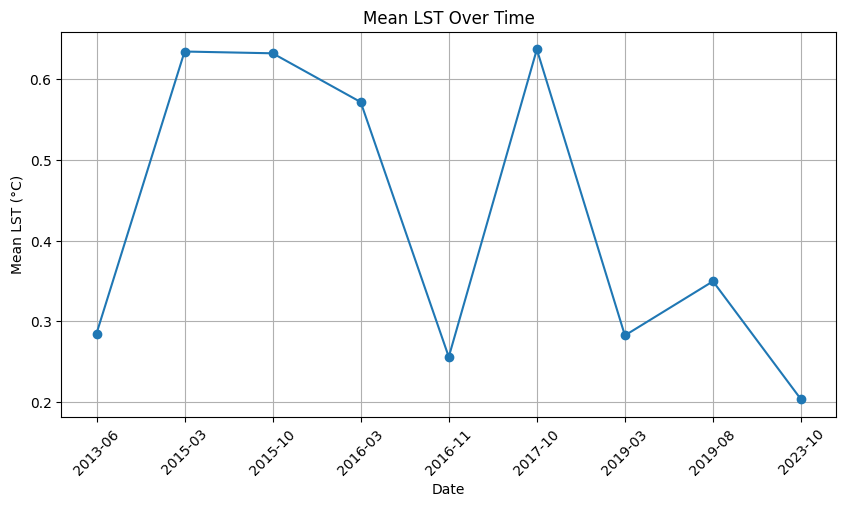

['2013-04', '2013-05', '2014-01', '2014-04', '2015-03', '2015-10', '2016-04', '2016-05', '2016-10', '2018-07', '2018-10', '2019-06', '2021-04', '2021-05', '2022-09', '2022-10', '2023-10']


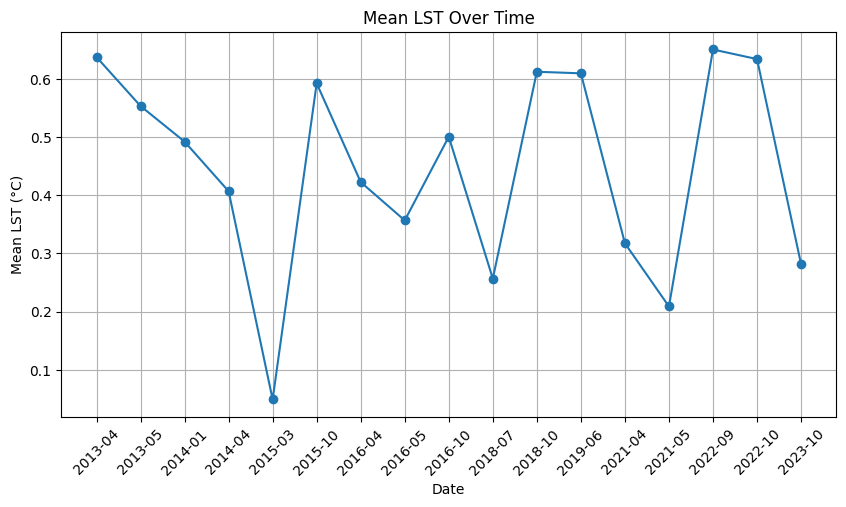

['2013-09', '2015-09', '2016-11', '2017-09', '2018-01', '2018-11', '2019-01', '2019-05', '2019-11', '2020-05', '2020-11', '2021-04', '2022-10', '2023-04', '2023-08']


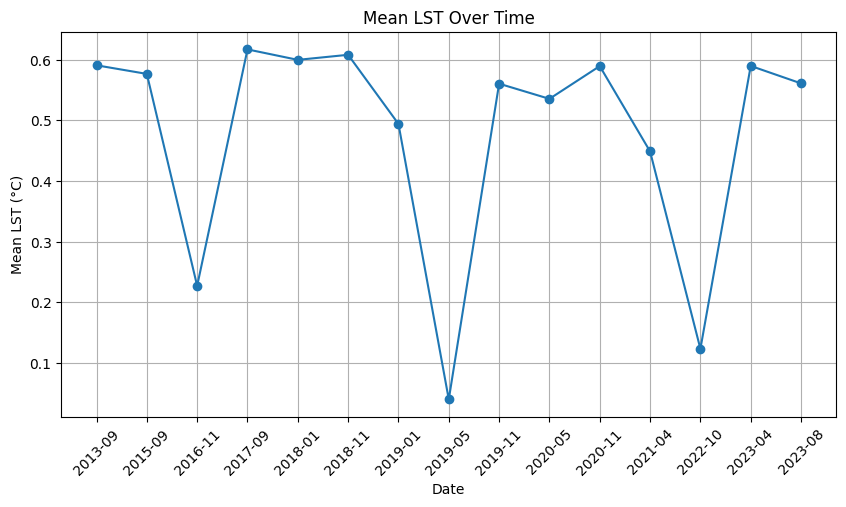

['2013-03', '2013-04', '2014-07', '2015-04', '2015-05', '2015-06', '2015-12', '2016-04', '2016-08', '2017-03', '2017-05', '2017-09', '2017-10', '2019-04', '2019-10', '2020-01', '2020-07', '2021-01', '2021-03', '2021-11', '2022-01', '2022-11', '2023-09', '2024-01', '2024-02', '2024-06', '2024-07', '2024-08']


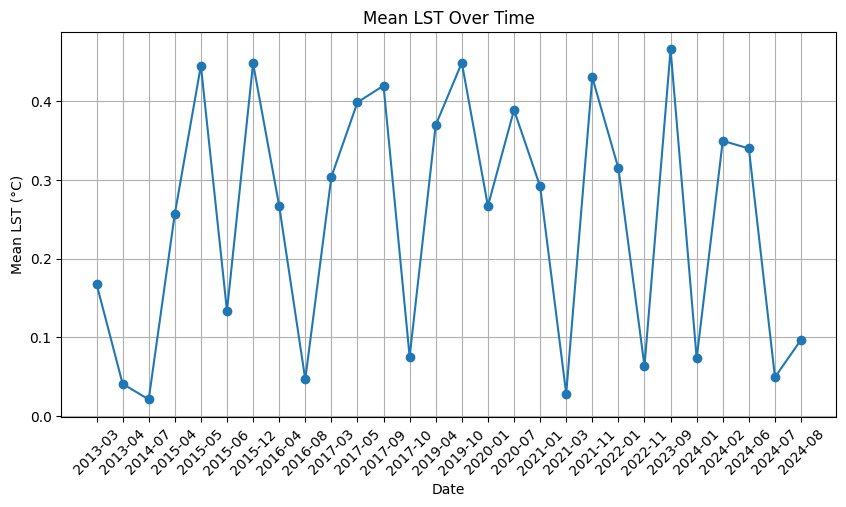

['2013-09', '2013-12', '2014-03', '2014-05', '2015-01', '2016-04', '2016-06', '2017-06', '2018-04', '2019-05', '2019-08', '2020-04', '2020-09', '2022-12', '2024-06', '2024-08']


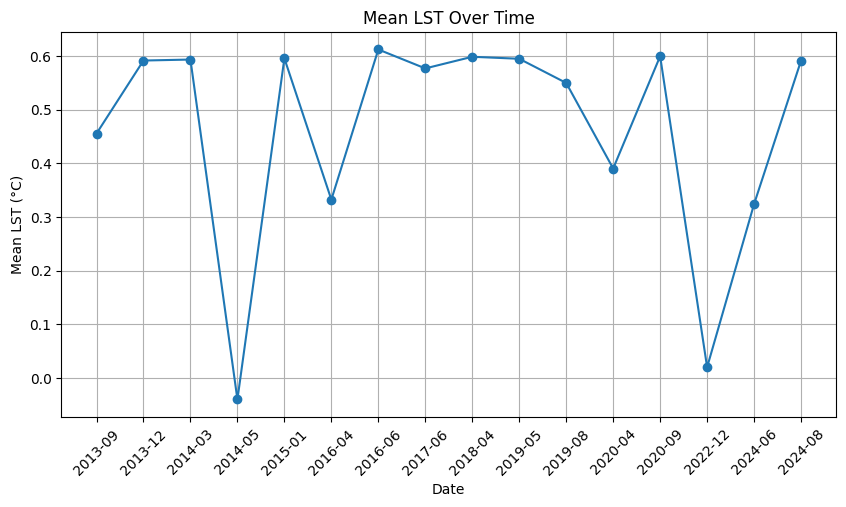

['2013-09', '2013-10', '2014-07', '2014-09', '2015-10', '2015-12', '2017-08', '2018-03', '2018-07', '2018-10', '2018-12', '2019-02', '2019-03', '2019-05', '2019-07', '2021-05', '2021-10', '2022-11', '2024-06', '2024-09']


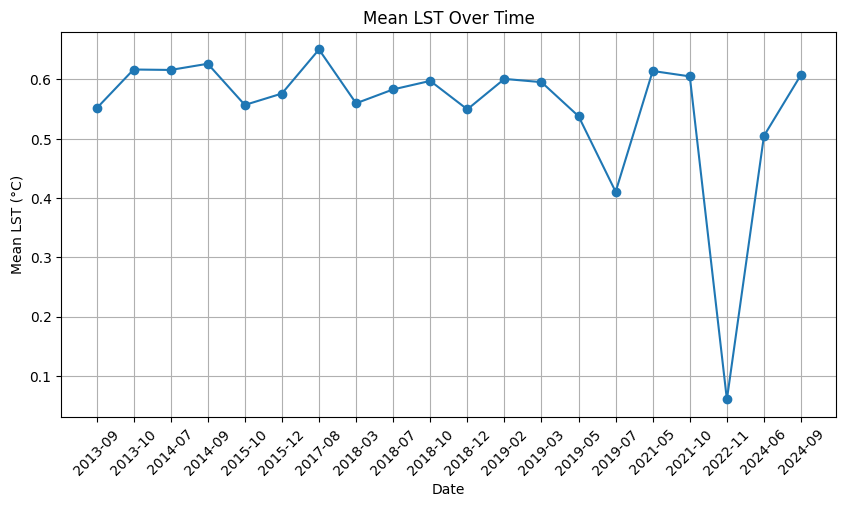

['2013-05', '2013-11', '2014-08', '2014-11', '2016-03', '2016-07', '2016-10', '2016-12', '2017-04', '2019-02', '2019-07', '2021-03', '2021-08', '2022-06', '2023-05', '2023-07', '2023-08', '2023-09', '2023-11', '2024-05', '2024-06', '2024-08', '2024-09']


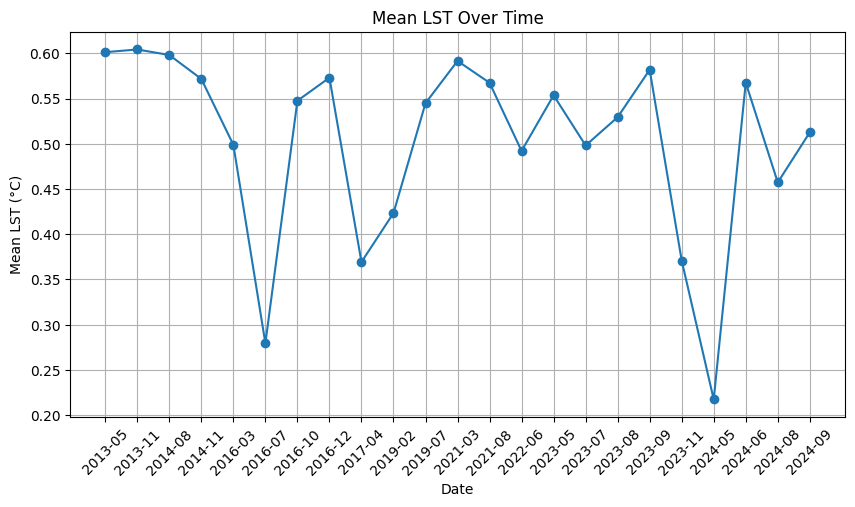

['2013-05', '2013-08', '2014-03', '2014-10', '2016-12', '2017-05', '2017-06', '2017-09', '2017-10', '2019-03', '2021-07', '2022-06', '2022-09', '2023-04', '2023-06', '2023-08', '2023-09', '2024-03', '2024-05']


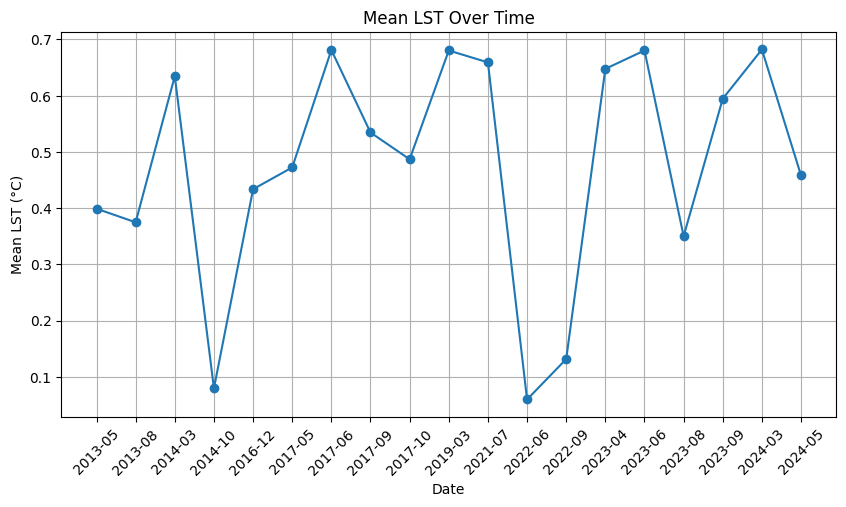

['2014-02', '2015-05', '2015-08', '2015-12', '2016-02', '2016-05', '2017-01', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2020-02', '2020-09', '2021-01', '2021-06', '2021-11', '2022-03', '2022-06', '2022-09', '2023-04', '2024-04']


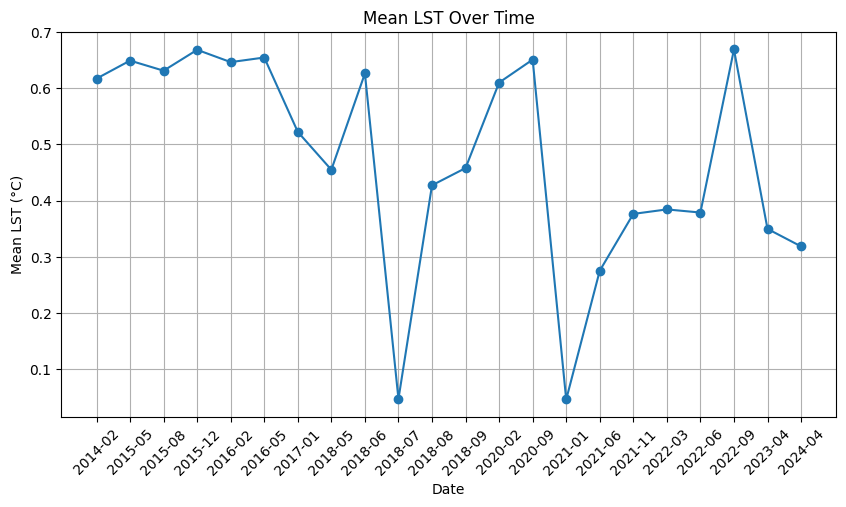

['2013-11', '2014-04', '2014-06', '2014-10', '2014-11', '2015-07', '2016-01', '2016-02', '2016-07', '2016-08', '2016-10', '2017-04', '2018-02', '2018-03', '2019-11', '2020-01', '2020-02', '2020-06', '2021-08', '2022-06', '2022-07', '2022-11', '2023-01', '2024-02', '2024-08']


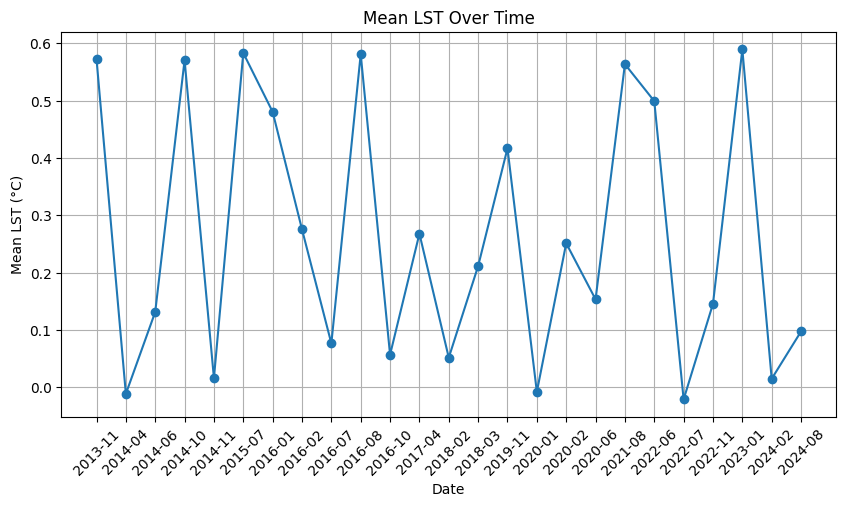

['2013-07', '2013-09', '2013-11', '2013-12', '2014-02', '2014-08', '2015-04', '2016-03', '2016-07', '2016-11', '2017-07', '2018-04', '2018-07', '2018-10', '2019-02', '2019-05', '2020-10', '2021-01', '2021-04', '2021-08', '2022-10', '2023-02', '2023-05', '2023-10', '2024-01', '2024-02']


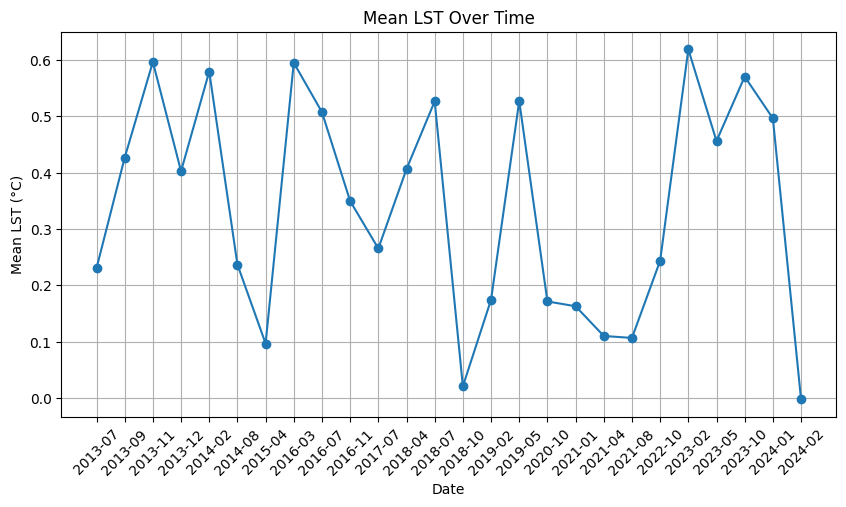

['2013-03', '2014-07', '2014-09', '2015-05', '2015-11', '2016-02', '2016-12', '2017-01', '2017-04', '2018-03', '2018-06', '2020-02', '2020-12', '2023-04', '2023-09', '2024-07']


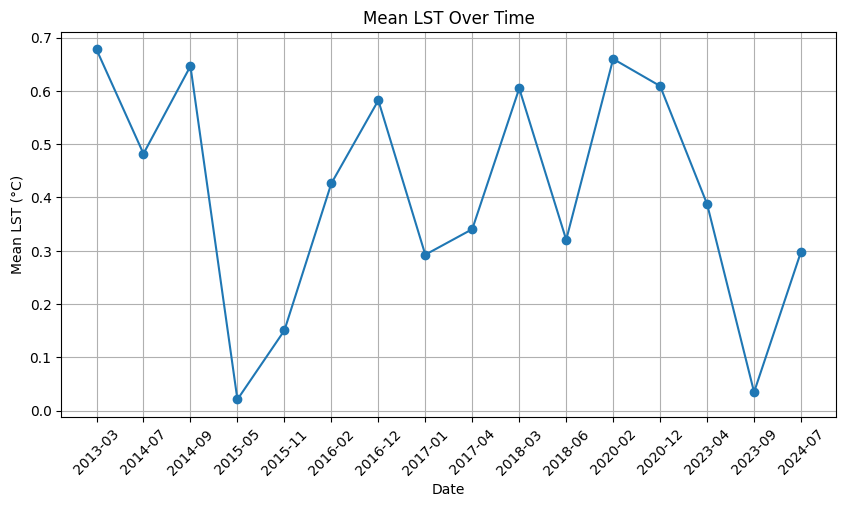

['2013-09', '2013-10', '2014-05', '2014-11', '2015-01', '2015-10', '2015-12', '2016-01', '2017-06', '2018-02', '2019-02', '2019-08', '2020-01', '2021-10', '2022-12', '2023-06', '2024-03', '2024-07', '2024-09']


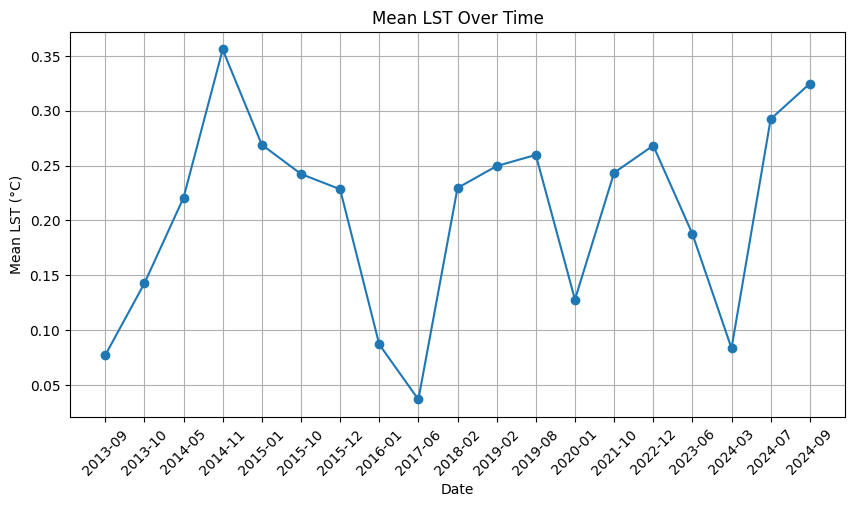

['2013-03', '2015-03', '2016-06', '2016-09', '2017-05', '2017-09', '2018-05', '2018-08', '2018-11', '2019-04', '2019-05', '2019-06', '2019-11', '2020-02', '2021-03', '2021-07', '2021-09', '2022-09', '2022-10', '2023-04', '2023-09', '2024-03']


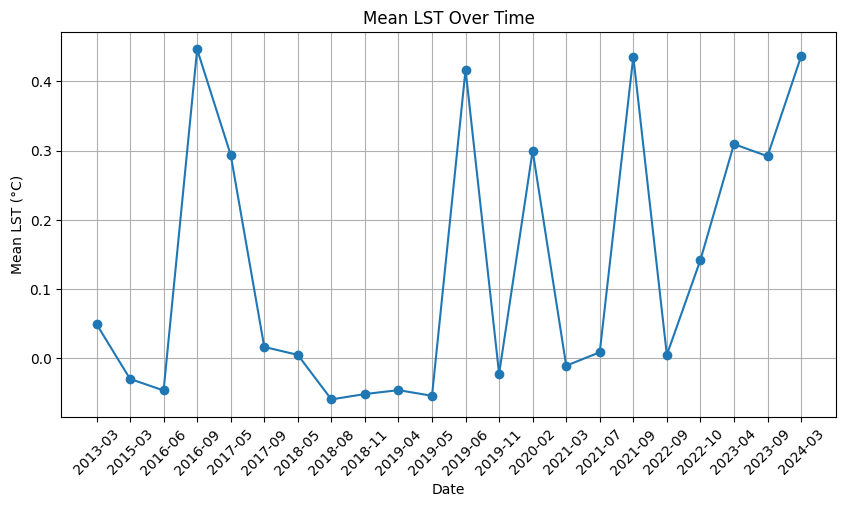

['2013-11', '2014-09', '2015-02', '2015-08', '2016-01', '2018-02', '2018-08', '2019-08', '2020-09', '2022-01', '2023-11']


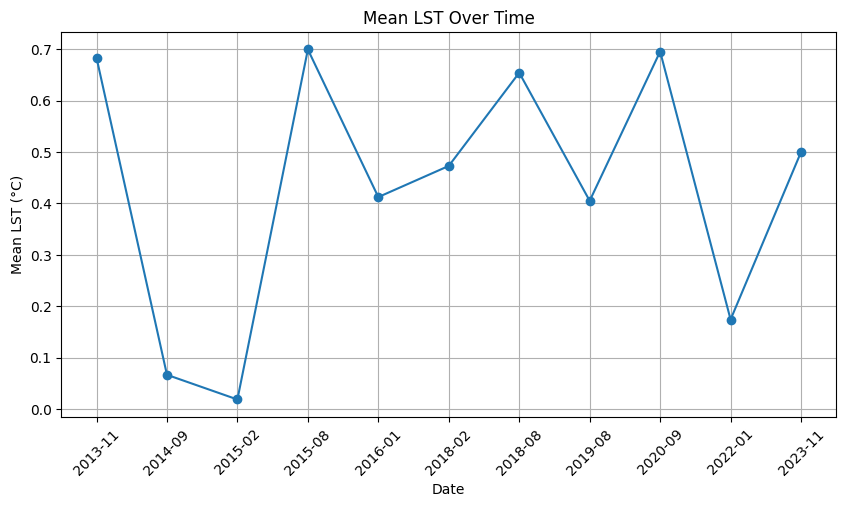

['2013-03', '2013-05', '2013-07', '2014-04', '2014-06', '2014-07', '2014-11', '2015-02', '2015-03', '2015-04', '2015-05', '2015-08', '2016-10', '2016-11', '2017-11', '2017-12', '2018-04', '2018-05', '2018-06', '2018-08', '2019-01', '2019-04', '2019-09', '2019-11', '2020-02', '2020-04', '2020-06', '2020-07', '2021-04', '2021-05', '2021-06', '2021-07', '2021-09', '2021-11', '2022-04', '2022-06', '2022-10', '2023-04', '2023-05', '2023-09', '2023-10', '2024-01', '2024-06', '2024-08']


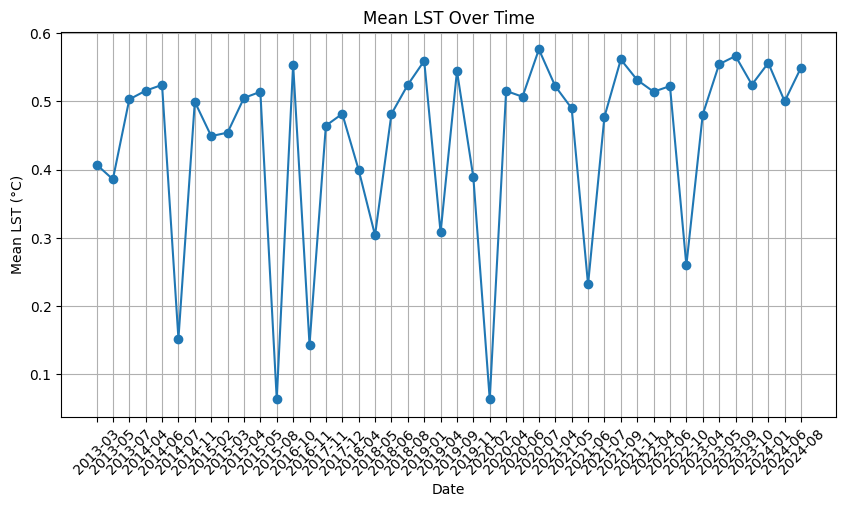

['2013-04', '2013-05', '2013-10', '2013-12', '2015-03', '2015-07', '2016-09', '2017-01', '2017-03', '2018-03', '2018-10', '2019-06', '2020-02', '2020-08', '2020-11', '2021-06', '2021-11', '2022-07', '2022-10', '2023-06', '2024-05']


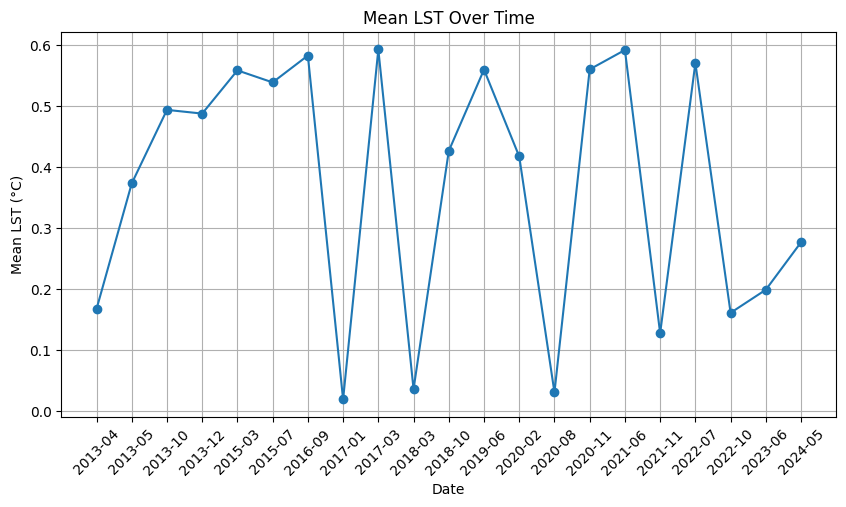

['2014-09', '2014-11', '2015-02', '2015-07', '2016-02', '2016-03', '2016-11', '2017-08', '2017-09', '2018-03', '2018-06', '2018-10', '2019-02', '2019-07', '2019-09', '2019-12', '2020-11', '2021-03', '2021-06', '2021-12', '2022-02', '2023-07', '2023-09']


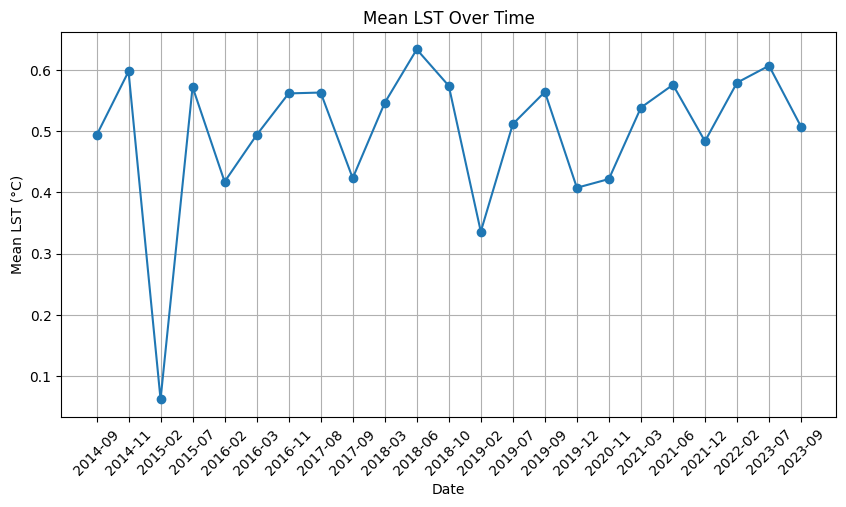

['2014-04', '2015-03', '2015-04', '2015-08', '2016-01', '2016-08', '2016-10', '2016-12', '2017-03', '2018-01', '2018-03', '2018-05', '2018-12', '2019-01', '2019-02', '2020-12', '2022-12', '2023-05', '2024-07']


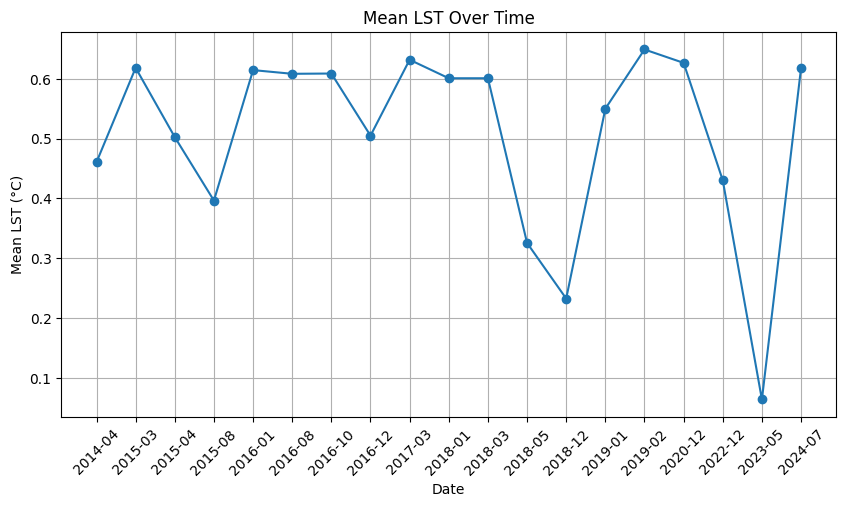

['2014-03', '2016-03', '2016-11', '2017-03', '2017-11', '2019-11', '2021-04', '2022-09', '2023-04', '2024-02', '2024-04']


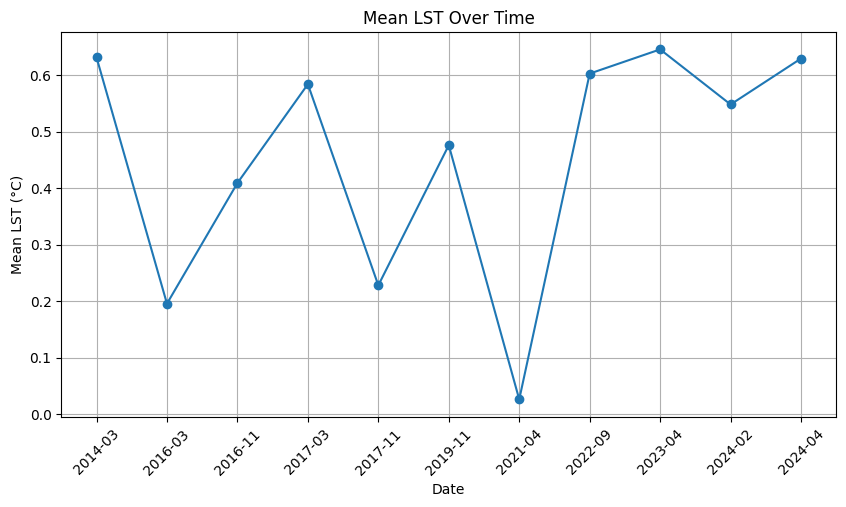

['2013-07', '2014-09', '2015-05', '2015-12', '2019-08', '2020-10', '2021-06', '2022-07', '2024-05']


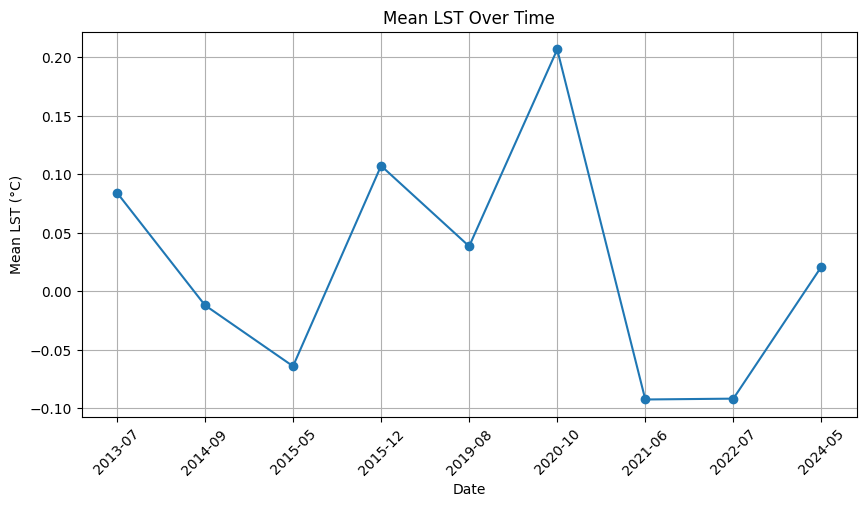

['2014-02', '2014-03', '2014-04', '2014-07', '2014-08', '2015-03', '2016-03', '2016-11', '2018-07', '2018-08', '2018-10', '2019-06', '2020-01', '2020-02', '2020-04', '2020-10', '2020-12', '2021-04', '2021-05', '2021-06', '2021-08', '2023-01', '2023-05', '2023-07', '2023-10', '2024-01', '2024-09']


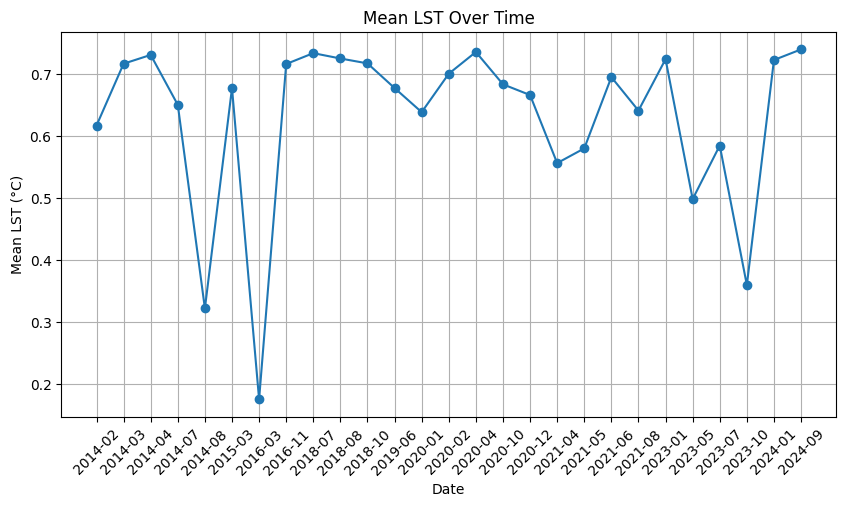

['2014-04', '2014-05', '2014-07', '2015-04', '2015-05', '2015-07', '2015-11', '2016-08', '2017-04', '2018-04', '2018-06', '2018-07', '2018-09', '2019-04', '2019-11', '2020-04', '2020-06', '2020-08', '2020-10', '2021-01', '2021-03', '2021-04', '2022-10', '2023-03', '2023-05', '2024-06']


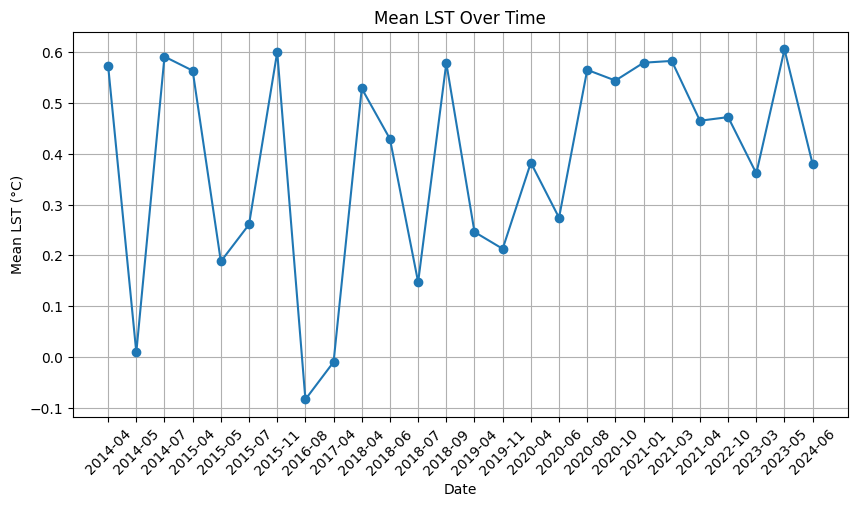

['2013-04', '2013-05', '2013-11', '2014-01', '2014-06', '2014-07', '2015-03', '2015-06', '2015-11', '2015-12', '2016-03', '2016-05', '2016-08', '2017-01', '2017-02', '2018-01', '2018-06', '2018-07', '2019-01', '2019-03', '2019-04', '2019-09', '2020-05', '2020-08', '2021-03', '2021-06', '2021-08', '2022-03', '2022-05', '2022-07', '2022-09', '2023-03', '2023-09', '2024-04', '2024-06']


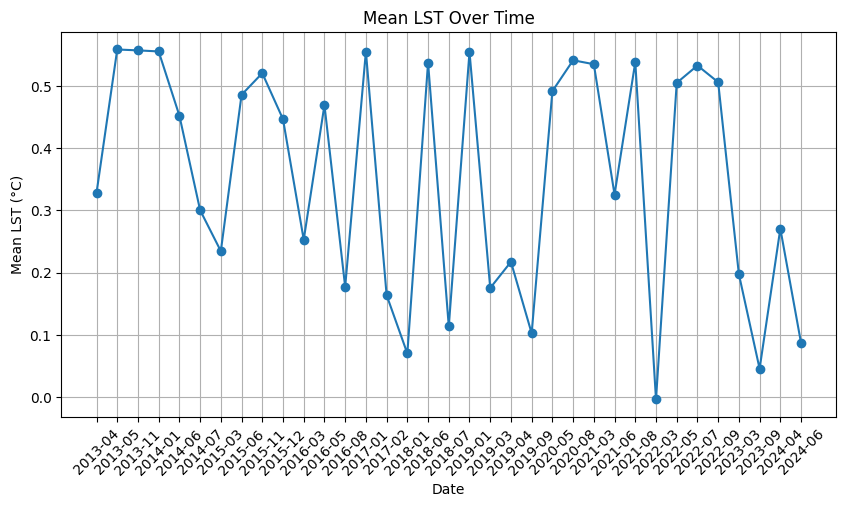

['2013-05', '2013-08', '2014-07', '2015-01', '2015-02', '2015-03', '2015-09', '2015-10', '2015-12', '2016-01', '2016-05', '2016-08', '2016-12', '2017-03', '2017-06', '2017-10', '2017-12', '2018-01', '2018-06', '2018-08', '2018-10', '2019-02', '2019-04', '2019-07', '2019-08', '2019-10', '2020-01', '2020-04', '2020-05', '2020-10', '2020-11', '2020-12', '2021-05', '2021-08', '2021-12', '2022-04', '2022-11', '2022-12', '2023-03', '2023-04', '2023-06', '2023-08', '2023-11', '2024-04', '2024-05', '2024-06']


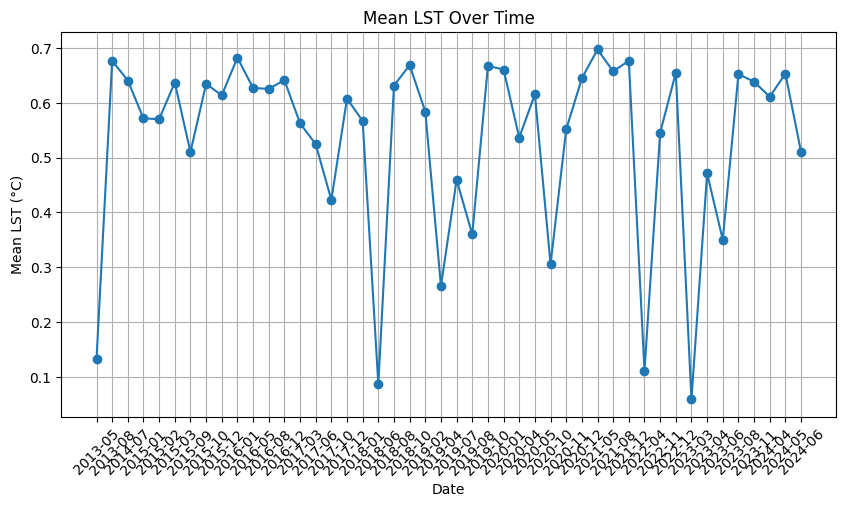

['2014-08', '2015-04', '2015-05', '2015-10', '2016-03', '2016-04', '2016-07', '2016-12', '2017-01', '2018-04', '2019-01', '2019-07', '2019-12', '2020-11', '2021-04', '2022-05', '2023-09']


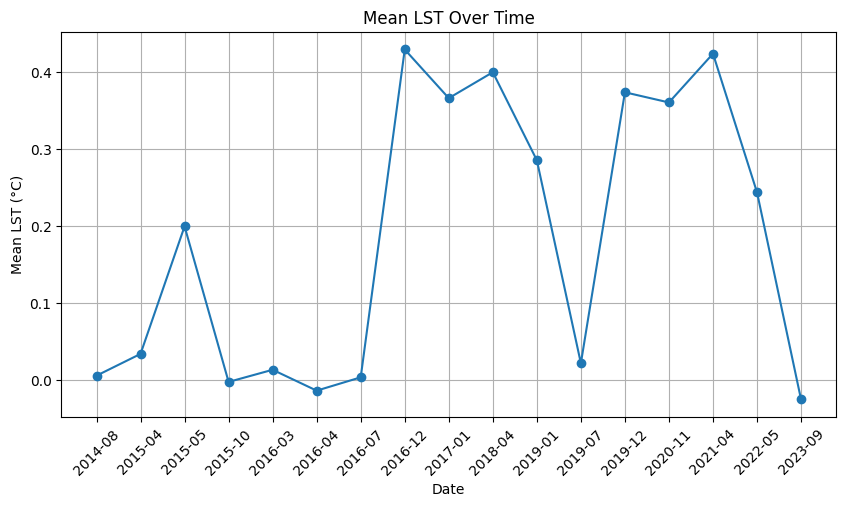

['2013-08', '2013-10', '2013-11', '2014-09', '2015-04', '2016-02', '2017-06', '2018-02', '2018-03', '2018-11', '2019-12', '2020-02', '2020-07', '2021-08', '2021-09', '2021-10', '2022-02', '2022-08', '2022-12', '2024-03', '2024-05']


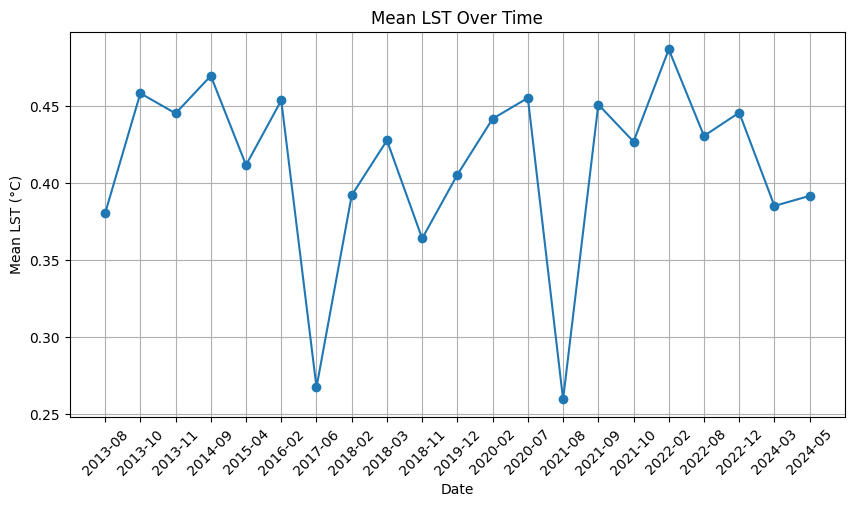

['2013-04', '2014-03', '2015-02', '2015-07', '2016-06', '2017-02', '2018-02', '2018-09', '2019-02', '2019-05', '2019-07', '2019-10', '2020-09', '2020-10', '2023-05', '2023-08', '2023-11', '2024-08', '2024-09']


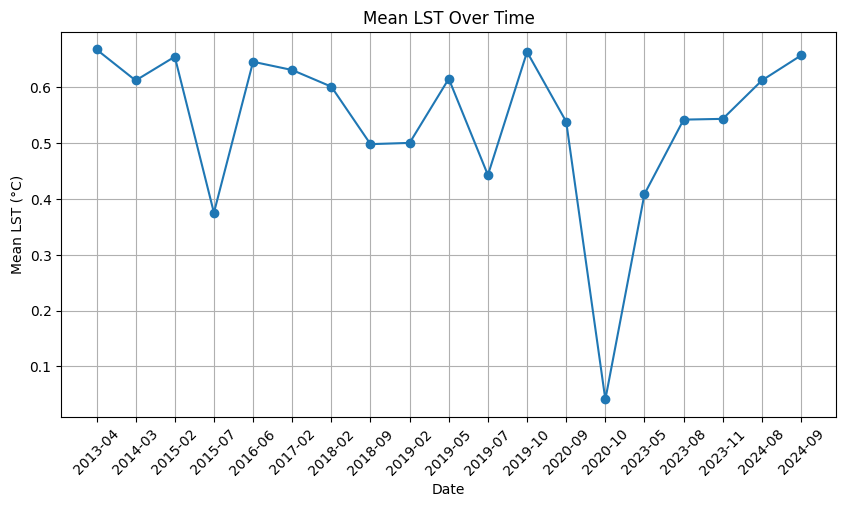

['2013-09', '2014-01', '2014-02', '2014-12', '2015-06', '2015-12', '2016-05', '2016-08', '2017-02', '2017-10', '2017-11', '2018-04', '2019-06', '2019-09', '2020-05', '2020-09', '2020-11', '2021-06', '2022-03', '2022-05', '2023-04', '2023-11', '2024-03', '2024-08']


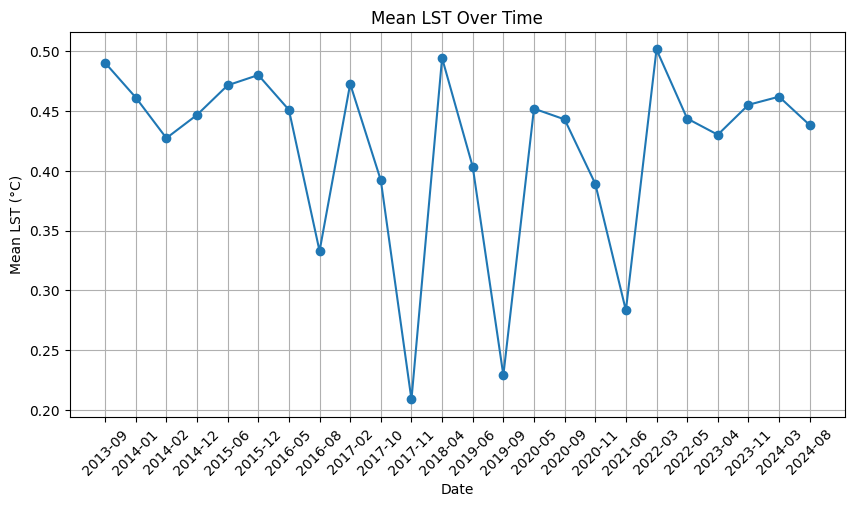

['2015-05', '2015-07', '2016-08', '2017-05', '2018-02', '2018-03', '2018-04', '2018-06', '2019-07', '2020-04', '2020-06', '2020-07', '2020-09', '2020-11', '2021-09', '2021-10', '2023-11', '2024-01', '2024-03']


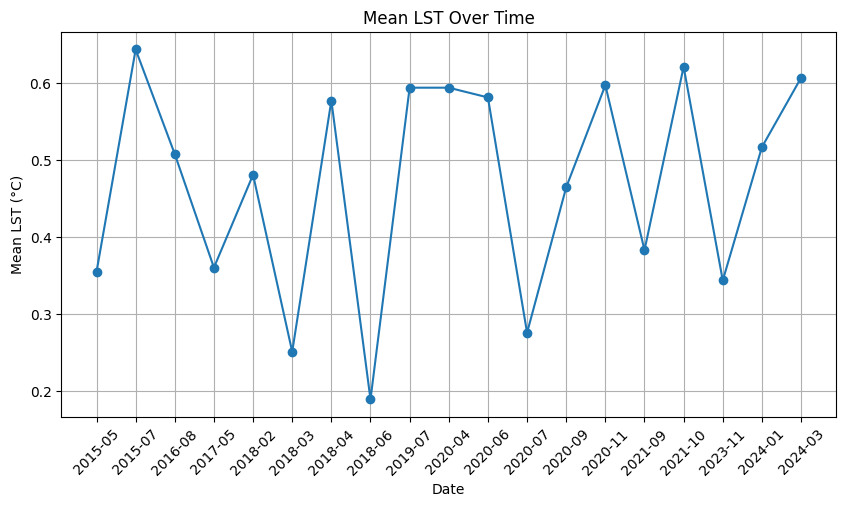

['2013-06', '2013-10', '2014-07', '2014-09', '2014-10', '2014-12', '2015-01', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2016-02', '2016-09', '2017-04', '2018-01', '2018-03', '2018-05', '2018-10', '2019-06', '2019-08', '2019-12', '2020-01', '2020-03', '2020-07', '2021-03', '2021-05', '2021-08', '2022-05', '2022-07', '2023-04', '2023-05', '2023-07', '2023-09', '2023-10', '2023-11', '2024-02', '2024-06', '2024-08', '2024-09']


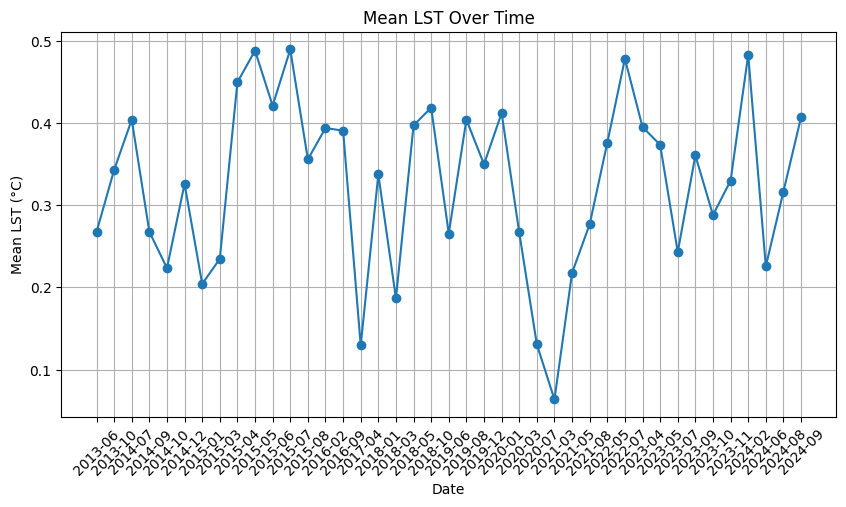

['2013-05', '2014-12', '2015-12', '2016-06', '2016-10', '2016-11', '2017-06', '2017-10', '2017-12', '2018-05', '2020-01', '2020-03', '2020-05', '2020-12', '2021-10', '2021-11', '2022-09', '2023-08', '2024-03', '2024-04']


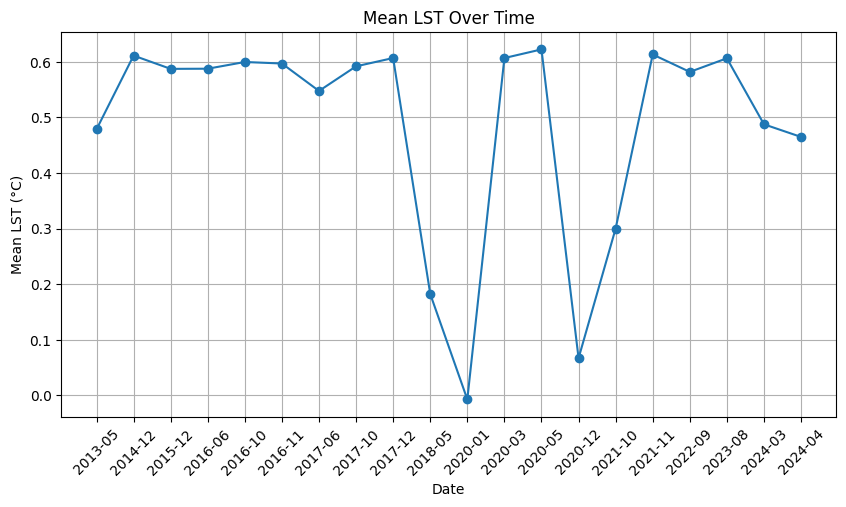

['2013-05', '2014-06', '2014-10', '2016-01', '2016-04', '2016-10', '2017-02', '2018-09', '2018-10', '2019-11', '2019-12', '2020-03', '2020-04', '2020-05', '2020-07', '2021-01', '2021-03', '2022-05', '2023-12']


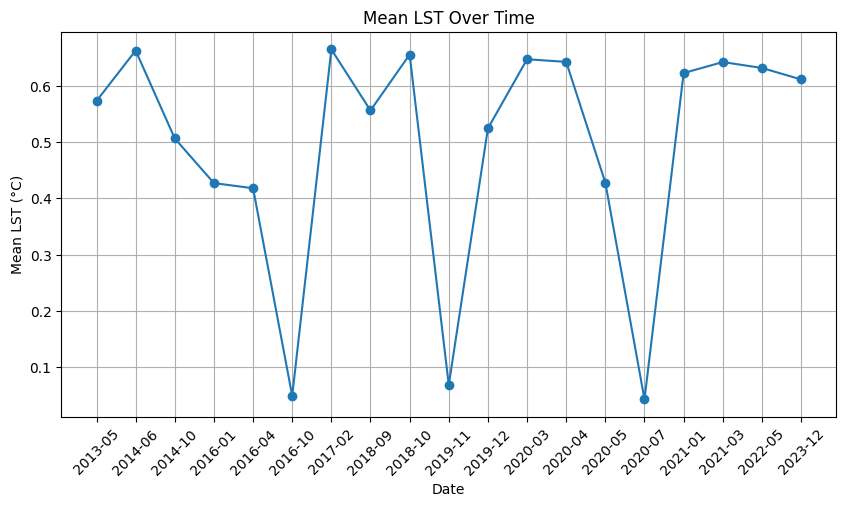

['2013-08', '2014-01', '2014-10', '2015-04', '2016-03', '2016-07', '2016-09', '2017-02', '2017-04', '2017-08', '2017-09', '2018-01', '2018-05', '2018-12', '2019-01', '2019-08', '2019-09', '2020-09', '2020-11', '2021-06', '2021-07', '2021-12', '2023-06', '2024-06']


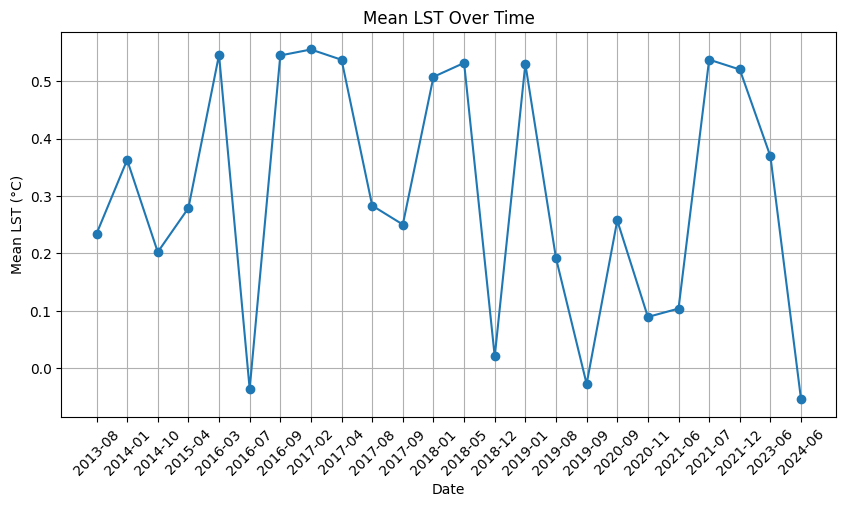

['2013-09', '2015-01', '2015-12', '2016-01', '2016-05', '2016-12', '2017-12', '2018-05', '2018-09', '2018-12', '2019-07', '2020-03', '2020-09', '2020-10', '2021-09', '2023-03', '2023-09']


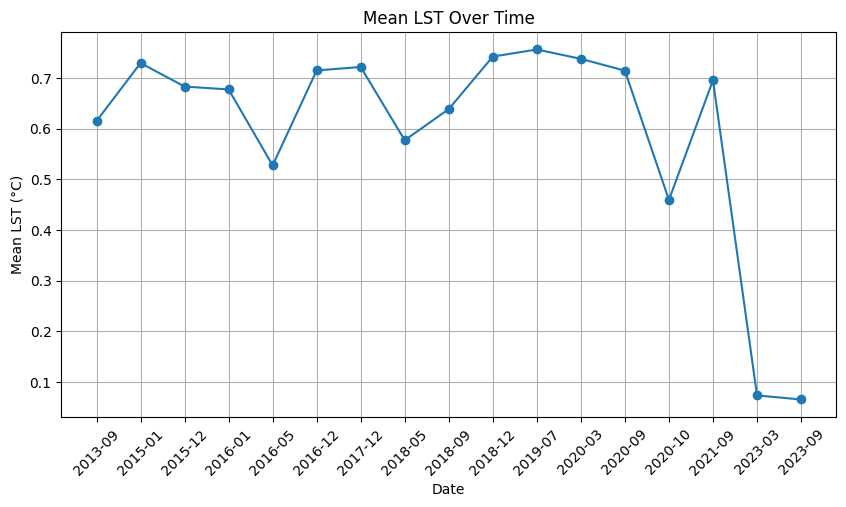

['2013-06', '2014-02', '2015-03', '2015-10', '2016-08', '2017-09', '2017-10', '2018-10', '2019-06', '2019-09', '2019-12', '2021-01', '2021-02', '2021-12', '2022-01', '2023-03', '2023-05', '2023-07', '2024-02', '2024-05']


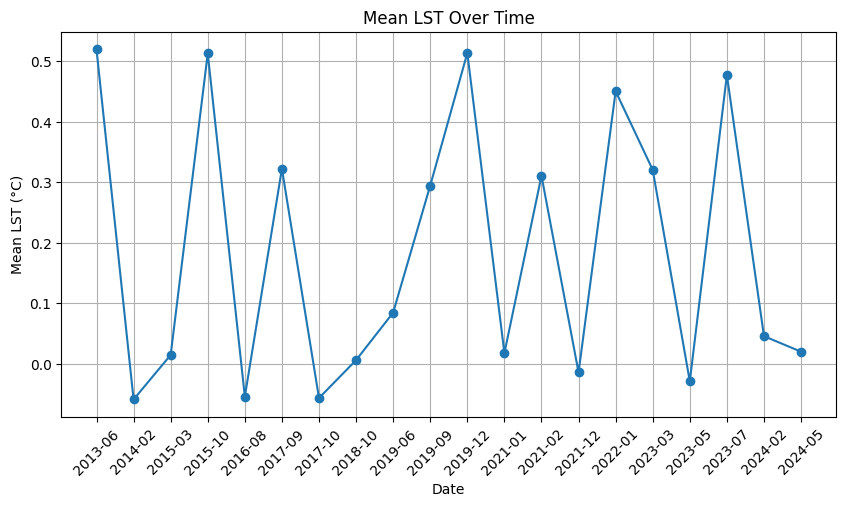

['2013-10', '2014-10', '2015-04', '2015-09', '2016-01', '2016-08', '2016-10', '2017-05', '2017-09', '2019-02', '2019-11', '2021-06', '2022-05', '2022-10', '2023-03', '2023-08', '2023-09']


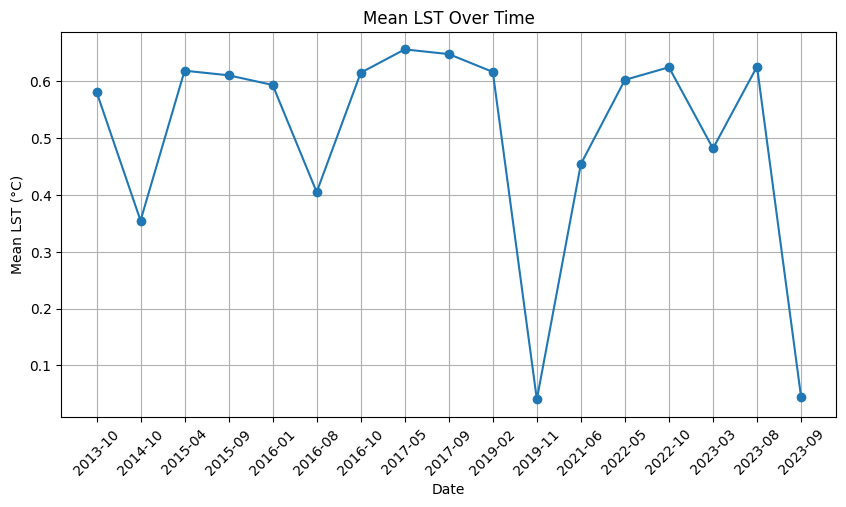

['2013-06', '2013-12', '2014-01', '2014-07', '2014-08', '2015-03', '2015-04', '2015-12', '2016-02', '2017-02', '2017-07', '2018-05', '2019-01', '2019-07', '2019-09', '2020-08', '2021-05', '2021-07', '2022-02', '2022-11', '2022-12', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2024-04', '2024-07']


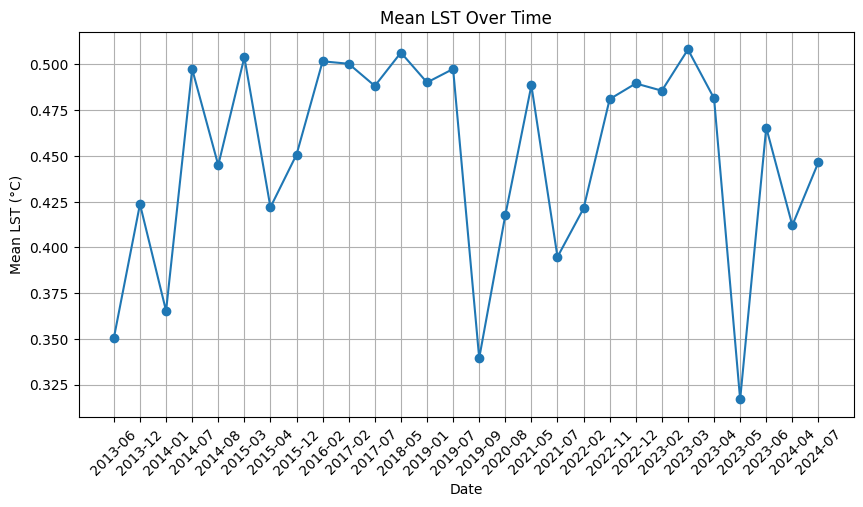

['2013-04', '2013-05', '2014-05', '2014-06', '2015-09', '2015-10', '2015-12', '2016-02', '2016-04', '2017-11', '2018-01', '2018-03', '2018-12', '2019-06', '2019-09', '2020-04', '2021-09', '2021-12', '2022-02', '2022-04', '2022-05', '2022-08', '2022-10', '2023-02', '2023-06', '2023-10', '2024-04']


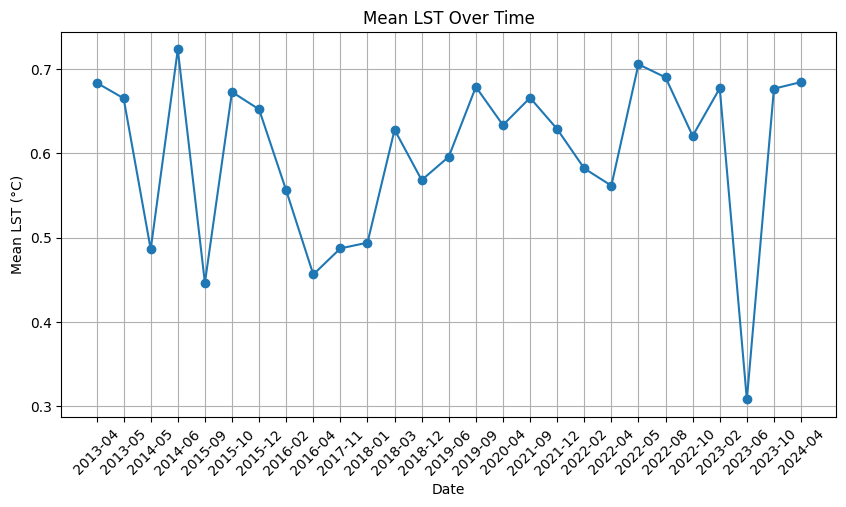

['2013-04', '2013-06', '2014-04', '2014-05', '2014-11', '2015-01', '2015-02', '2015-03', '2015-07', '2015-09', '2016-07', '2017-08', '2017-09', '2017-11', '2018-04', '2019-03', '2019-06', '2019-11', '2021-04', '2021-08', '2021-12', '2022-02', '2022-05', '2022-10', '2024-08']


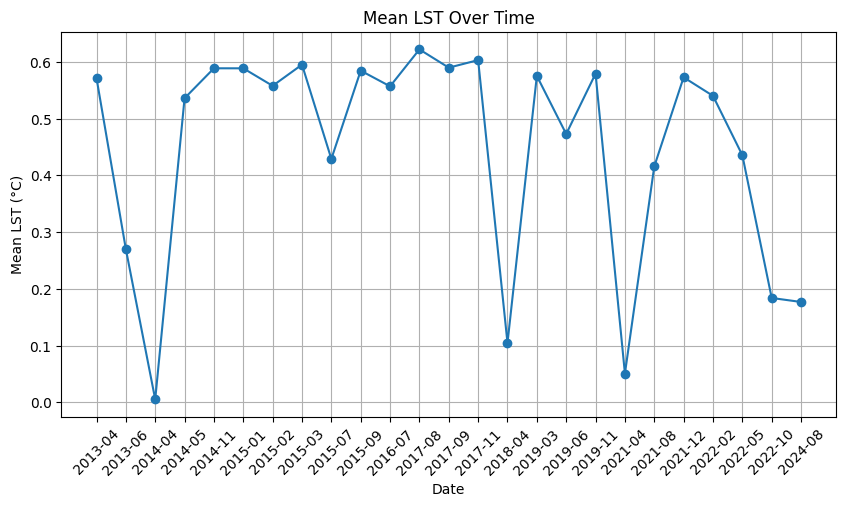

['2013-07', '2014-05', '2014-06', '2014-07', '2015-01', '2015-03', '2015-06', '2015-08', '2015-10', '2016-09', '2016-11', '2017-02', '2017-08', '2018-02', '2019-07', '2020-08', '2021-01', '2022-04', '2022-09', '2023-04', '2023-05', '2023-12', '2024-09']


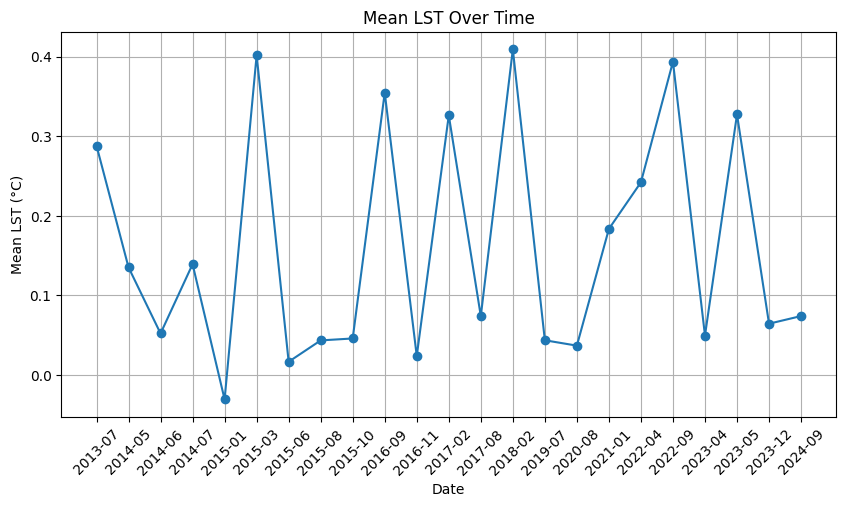

['2013-07', '2013-08', '2014-05', '2014-07', '2015-03', '2015-08', '2015-11', '2016-01', '2017-11', '2018-03', '2018-05', '2018-10', '2018-11', '2019-02', '2020-04', '2020-07', '2021-05', '2021-09', '2022-02', '2022-05', '2022-07', '2022-12', '2023-04', '2023-12', '2024-03', '2024-09']


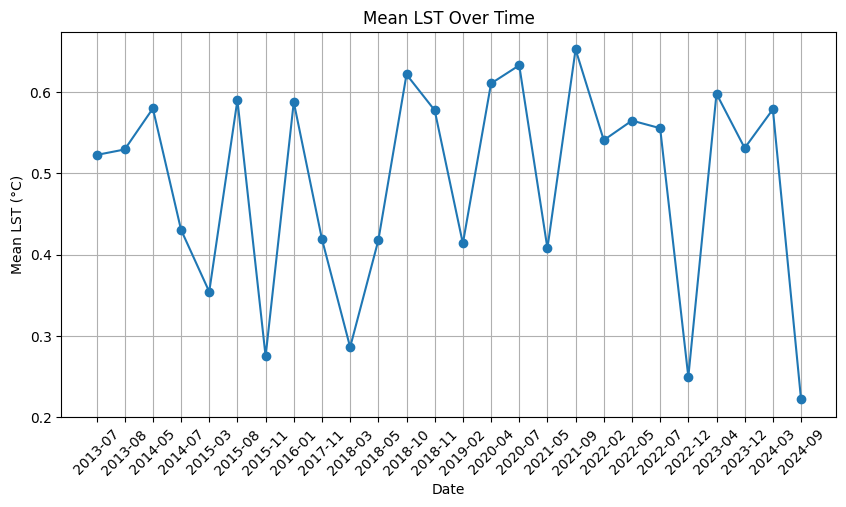

['2014-04', '2016-11', '2017-06', '2019-12', '2021-01']


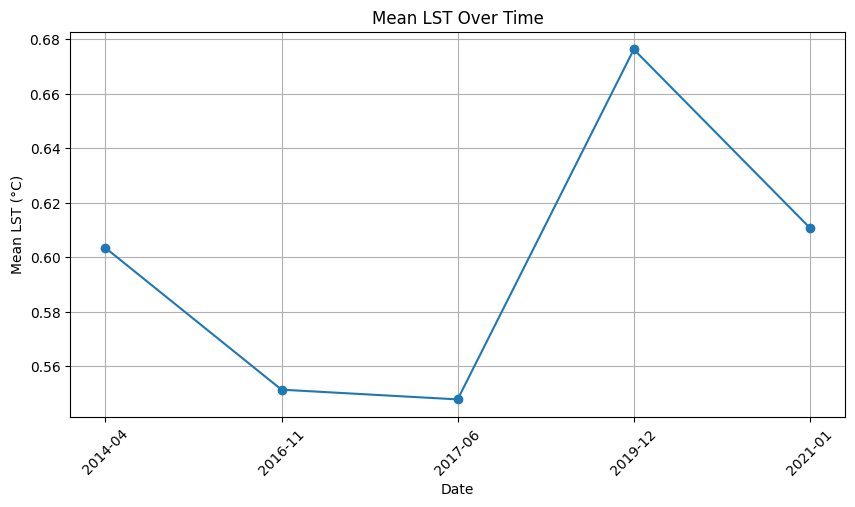

['2013-11', '2014-01', '2014-05', '2014-07', '2014-08', '2014-10', '2017-06', '2018-07', '2018-10', '2019-08', '2021-01', '2022-09', '2023-02', '2023-07', '2023-09', '2024-04']


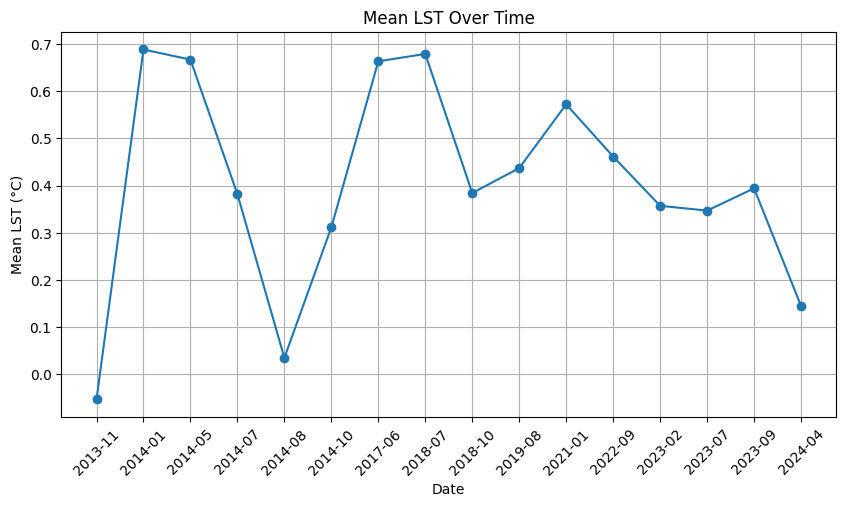

['2014-10', '2015-12', '2016-11', '2017-04', '2017-06', '2017-11', '2018-02', '2018-05', '2019-06', '2019-07', '2019-09', '2019-11', '2020-01', '2020-02', '2020-04', '2021-02', '2021-06', '2022-02', '2022-05', '2022-10', '2022-11', '2023-02', '2023-06', '2023-09', '2024-02', '2024-06']


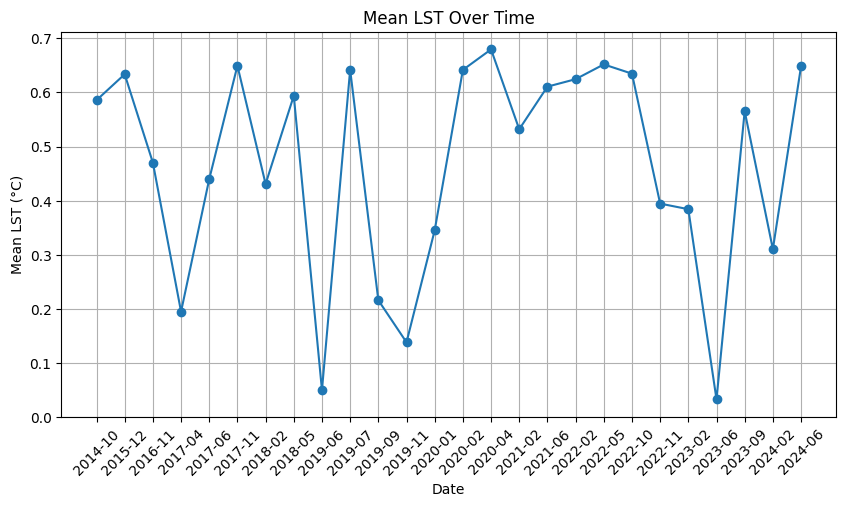

['2013-04', '2013-06', '2014-08', '2015-03', '2021-06', '2022-06', '2023-08', '2024-04']


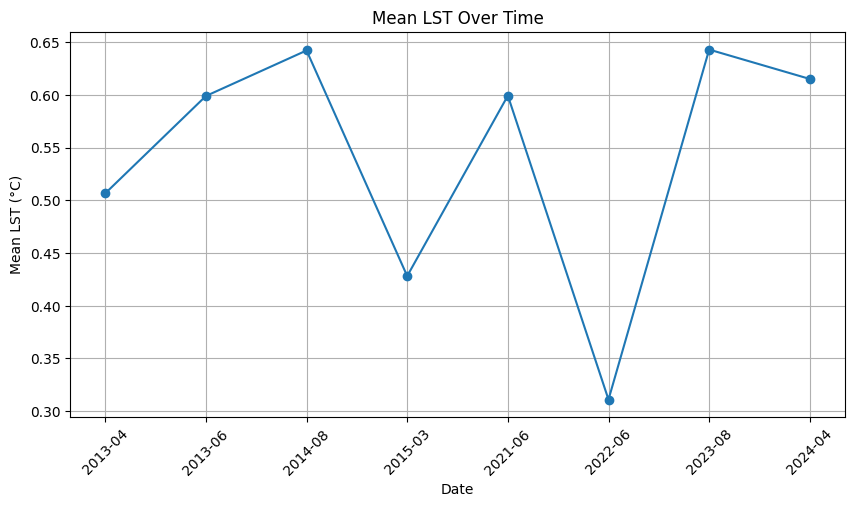

['2013-06', '2013-08', '2013-09', '2014-09', '2015-07', '2016-06', '2016-10', '2017-02', '2017-07', '2017-09', '2018-03', '2018-04', '2018-05', '2018-07', '2019-01', '2019-05', '2019-06', '2020-05', '2020-07', '2020-08', '2021-12', '2023-10', '2024-01']


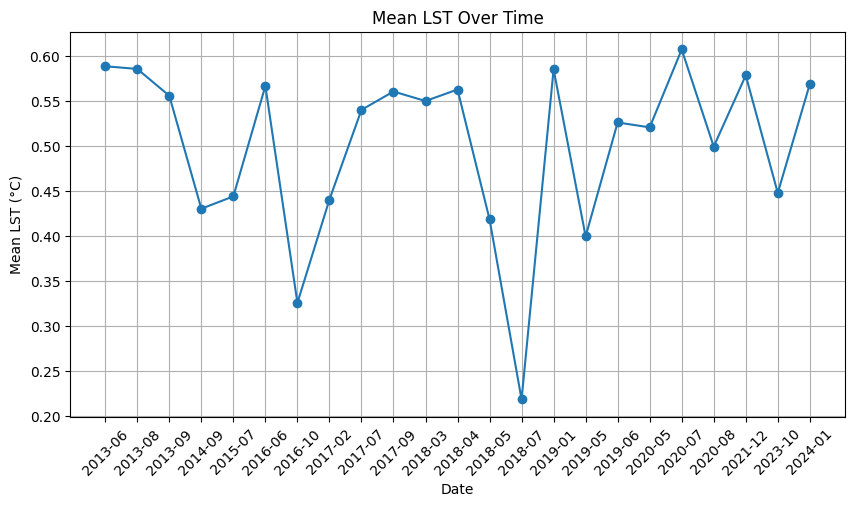

['2017-05', '2022-11', '2023-01', '2023-06']


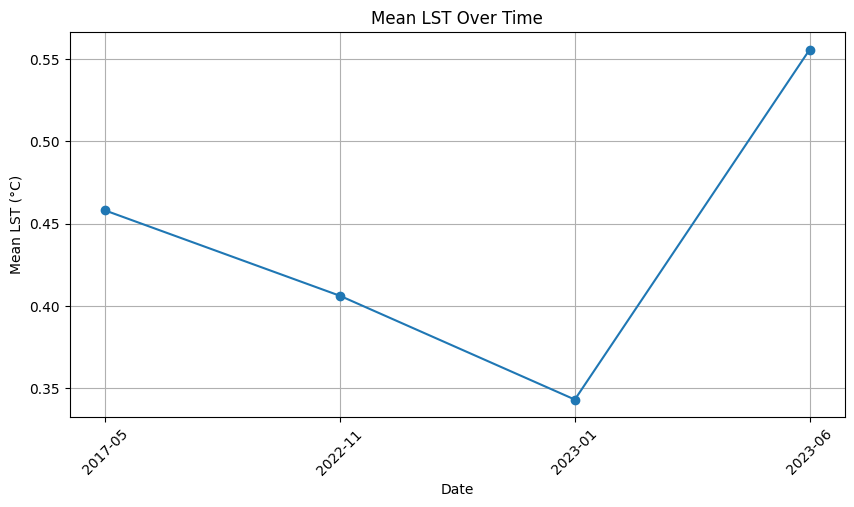

['2013-11', '2014-04', '2016-01', '2017-01', '2018-05', '2018-09', '2018-12', '2019-01', '2020-02', '2020-03', '2020-04', '2020-08', '2020-11', '2022-02', '2022-10']


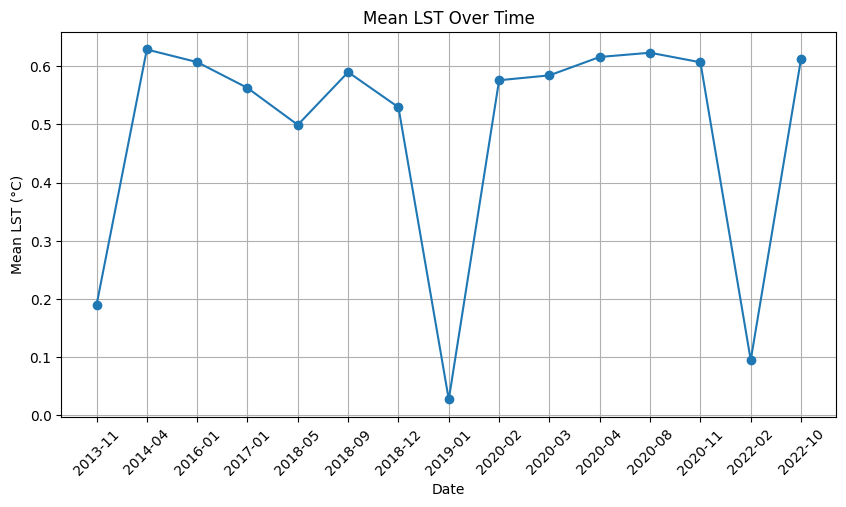

['2013-10', '2015-10', '2018-12', '2020-01', '2020-11', '2021-12', '2022-08']


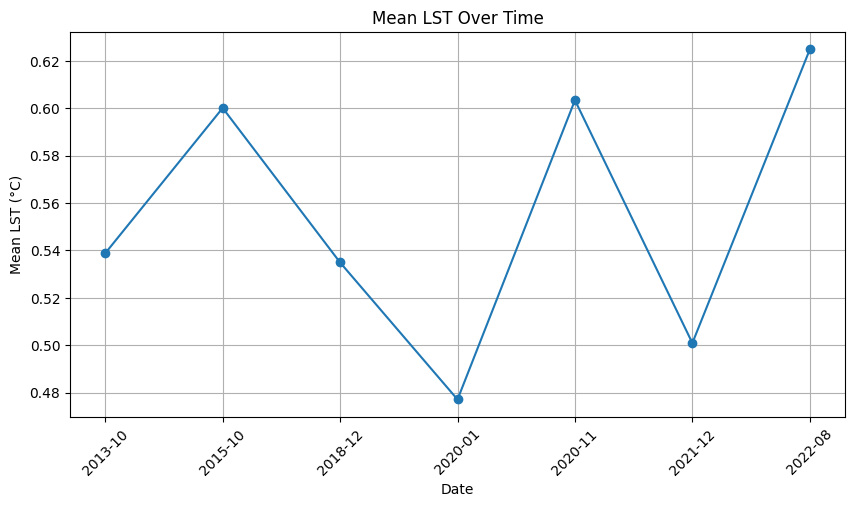

['2013-03', '2014-05', '2014-08', '2015-02', '2015-04', '2015-09', '2016-03', '2017-01', '2017-03', '2017-06', '2018-12', '2019-08', '2019-10', '2020-10', '2021-11', '2022-03', '2023-06', '2023-12']


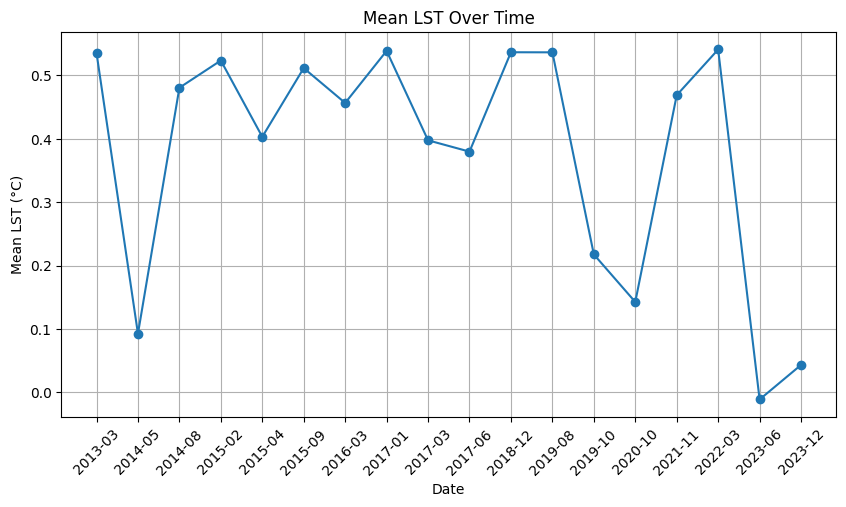

['2013-03', '2013-05', '2015-01', '2015-09', '2015-12', '2016-02', '2016-08', '2017-11', '2018-05', '2018-06', '2019-04', '2019-09', '2019-10', '2021-07', '2022-01', '2022-04', '2023-05', '2023-06', '2023-10', '2024-08']


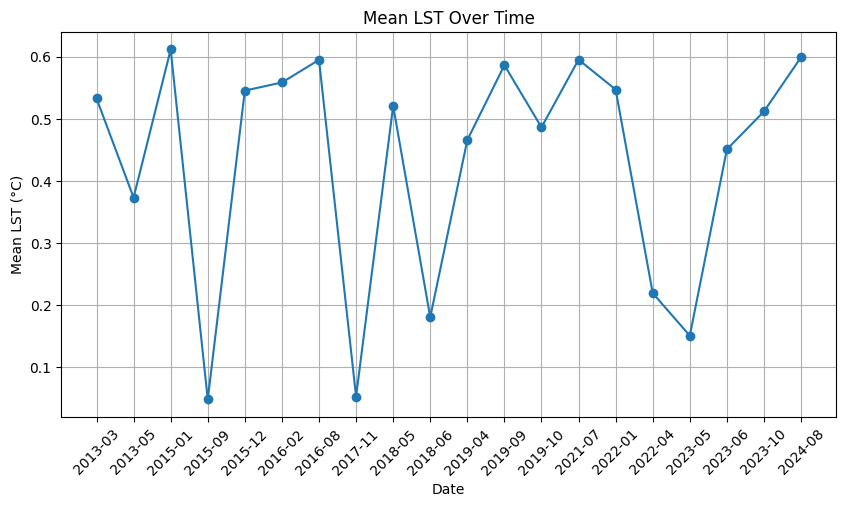

['2014-04', '2014-09', '2014-11', '2015-12', '2016-02', '2016-03', '2017-09', '2018-06', '2019-04', '2019-06', '2020-05', '2021-08', '2022-12', '2023-06', '2024-09']


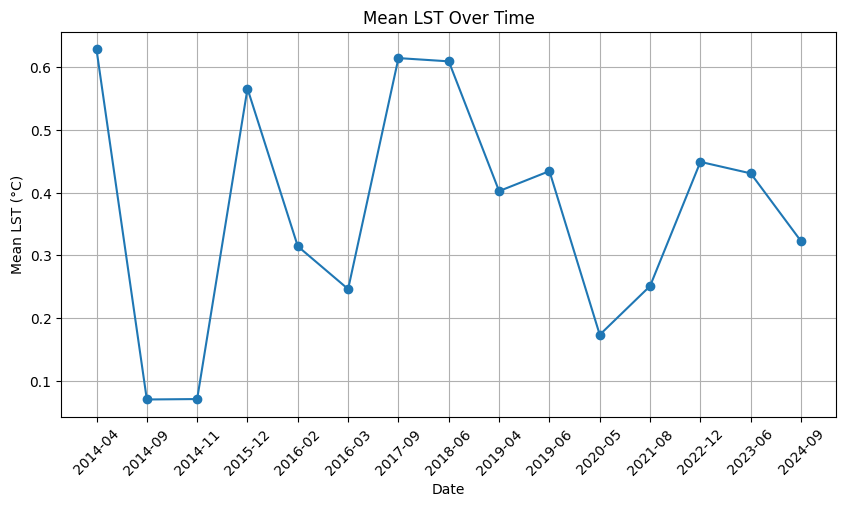

['2014-01', '2014-02', '2015-02', '2015-09', '2015-11', '2016-02', '2017-04', '2017-05', '2017-06', '2018-01', '2019-03', '2020-01', '2020-02', '2020-09', '2021-02', '2022-08', '2022-11', '2022-12', '2023-07']


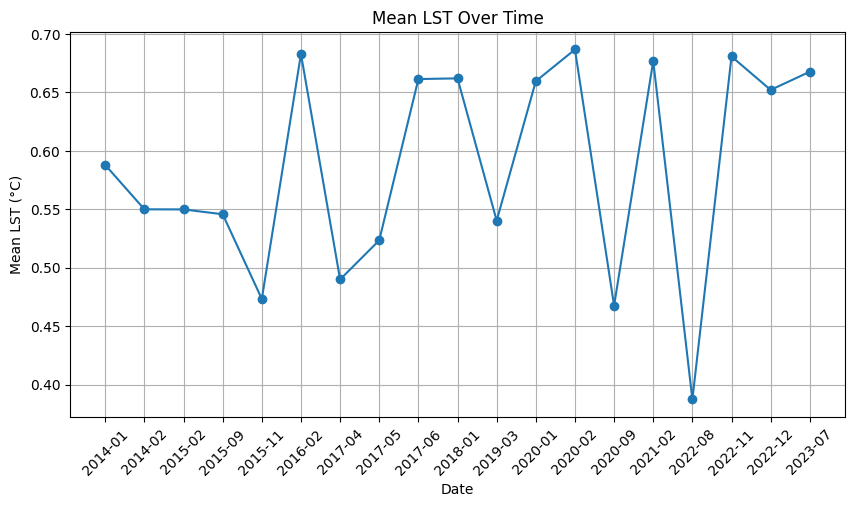

['2013-03', '2013-08', '2014-02', '2014-04', '2014-11', '2016-07', '2018-12', '2019-06', '2020-10', '2021-01', '2021-09', '2022-07', '2024-02']


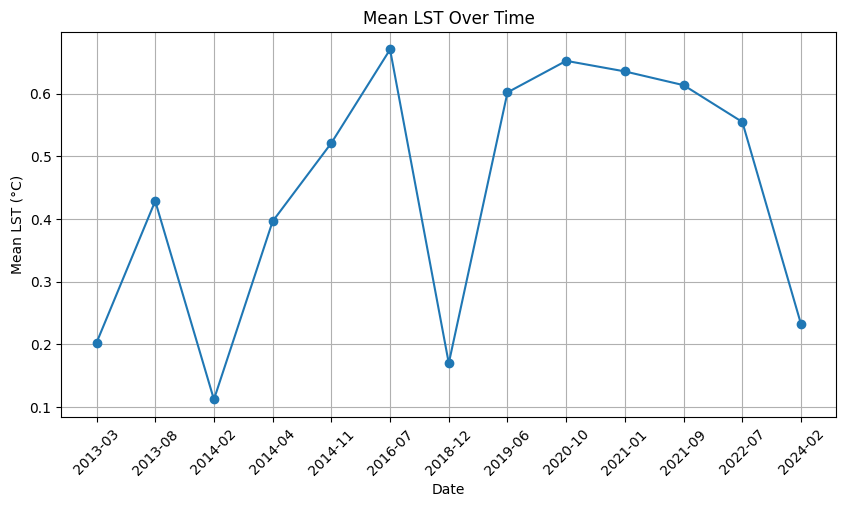

['2013-12', '2014-03', '2014-08', '2015-01', '2016-02', '2016-05', '2017-04', '2017-08', '2018-01', '2018-05', '2018-06', '2018-09', '2019-01', '2020-05', '2020-06', '2020-10', '2021-10', '2023-03', '2023-10', '2024-03']


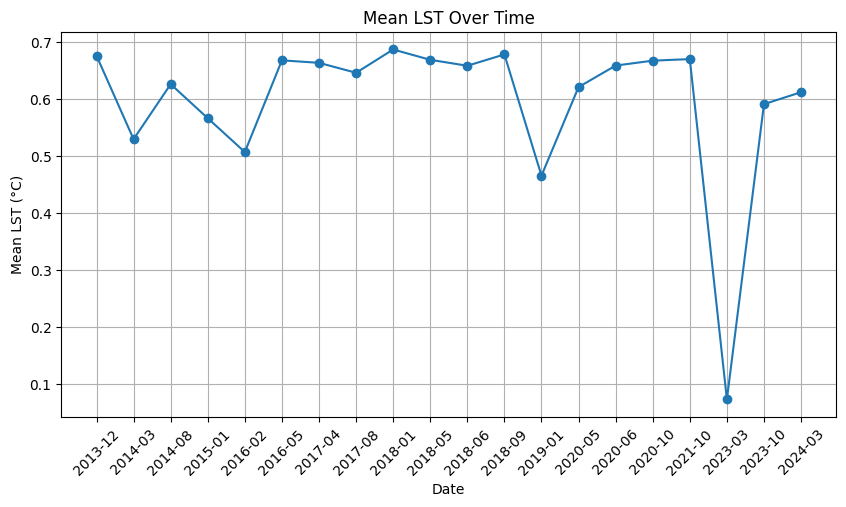

['2013-04', '2013-11', '2014-06', '2015-03', '2015-04', '2015-10', '2017-10', '2017-12', '2018-01', '2018-05', '2018-08', '2018-10', '2019-06', '2019-10', '2020-02', '2021-02', '2022-01', '2022-04', '2022-07', '2023-04']


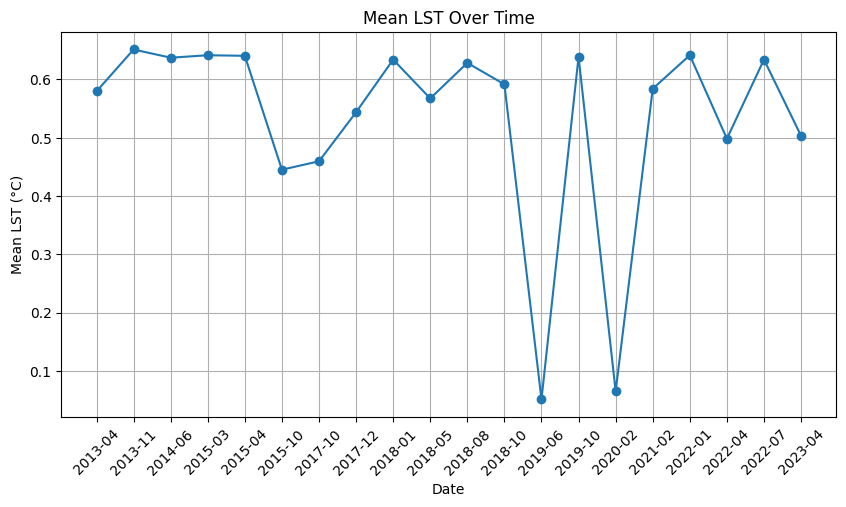

['2013-06', '2014-09', '2016-11', '2017-08', '2018-01', '2018-09', '2019-08', '2019-10', '2020-01', '2020-05', '2021-12', '2023-04', '2023-10']


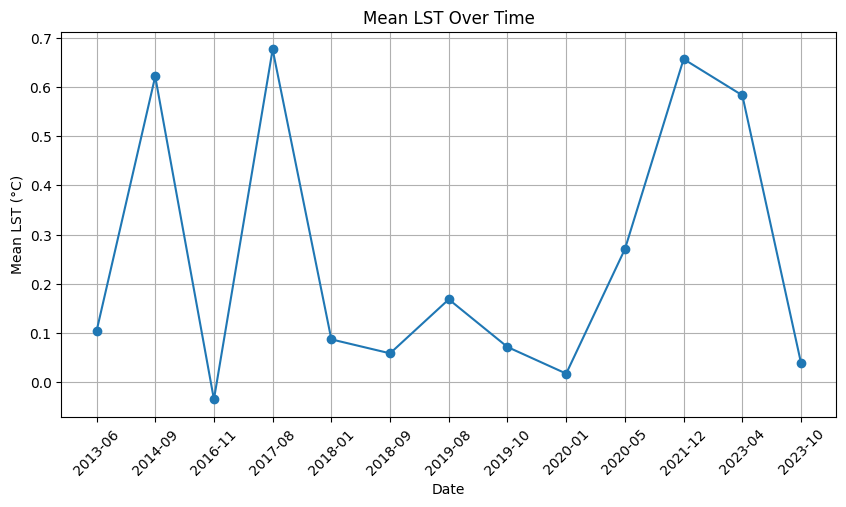

['2015-02', '2015-04', '2017-11', '2018-10', '2019-08', '2020-09', '2022-03', '2022-09', '2023-02', '2024-08', '2024-09']


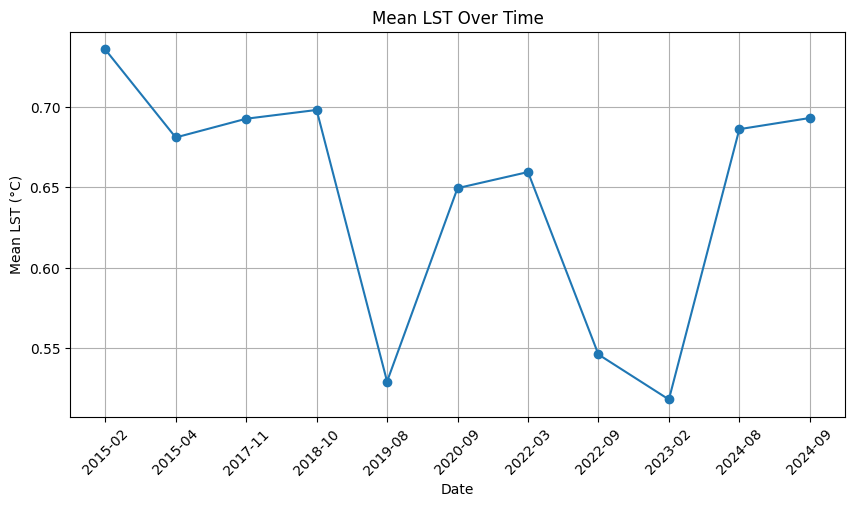

['2013-08', '2014-05', '2014-08', '2016-10', '2017-03', '2017-08', '2021-07', '2024-03']


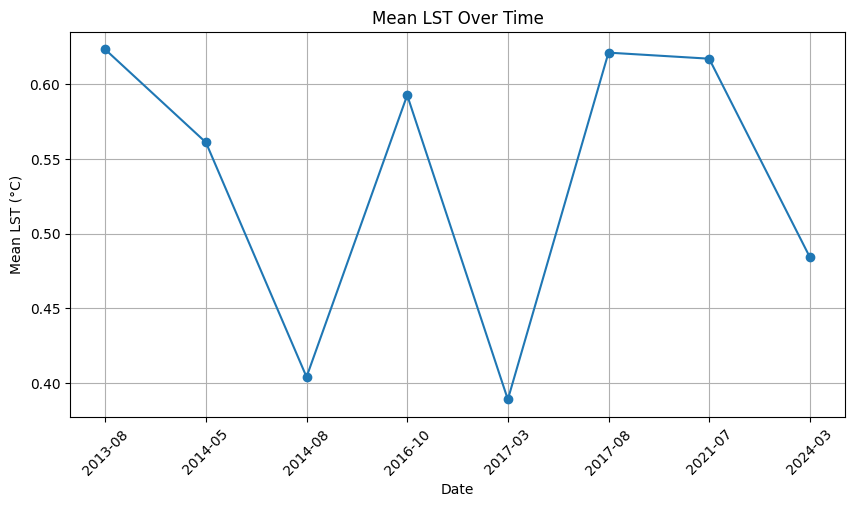

['2013-04', '2014-06', '2015-04', '2015-05', '2015-07', '2016-02', '2016-05', '2017-01', '2017-05', '2017-08', '2018-02', '2018-04', '2018-07', '2019-07', '2020-06', '2021-04', '2022-01', '2022-07', '2023-04', '2024-04']


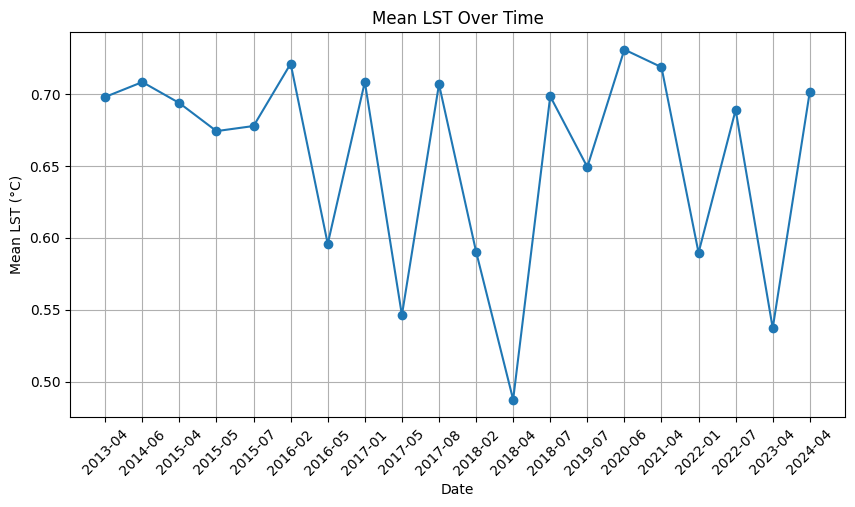

['2013-05', '2015-03', '2015-07', '2016-01', '2016-12', '2018-02', '2018-12', '2019-07', '2019-08', '2023-01']


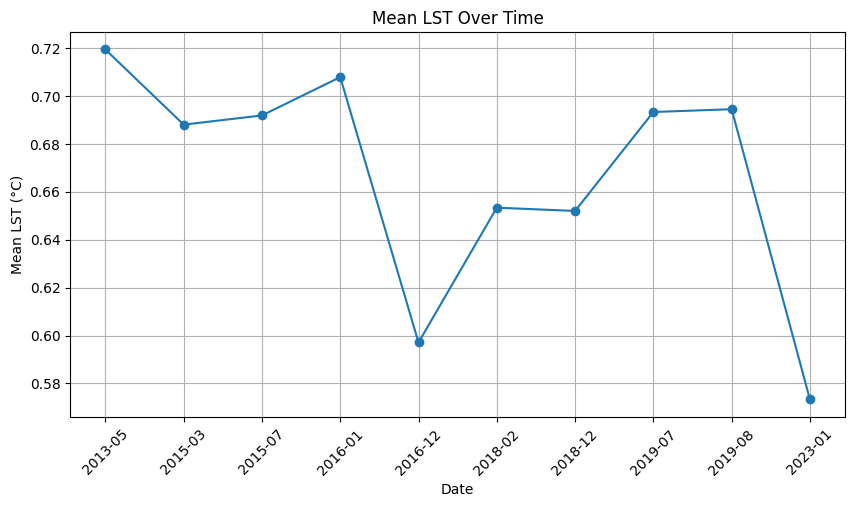

['2013-05', '2014-06', '2014-10', '2015-02', '2015-04', '2015-06', '2016-02', '2016-06', '2016-10', '2017-02', '2017-04', '2017-11', '2018-02', '2018-08', '2018-11', '2018-12', '2019-01', '2019-03', '2019-06', '2019-08', '2019-10', '2020-04', '2020-09', '2021-08', '2021-12', '2022-01', '2022-05', '2022-10', '2023-01', '2023-02', '2024-05', '2024-07']


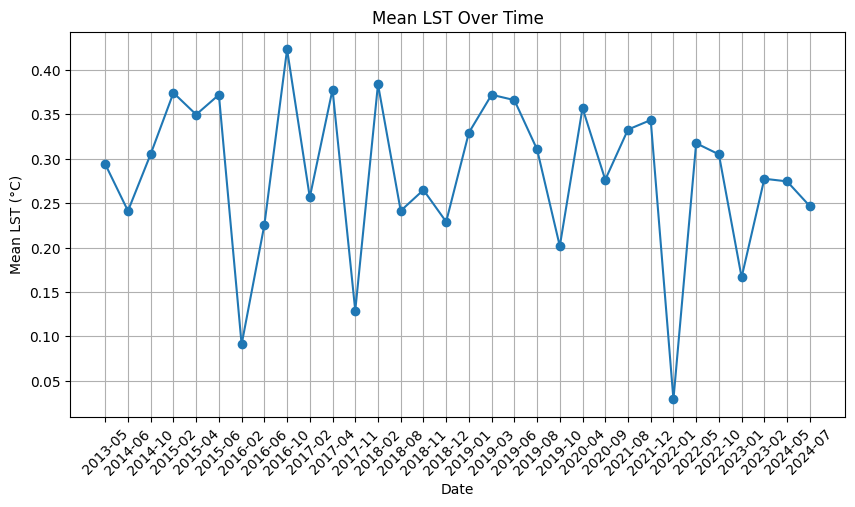

['2013-03', '2013-08', '2013-12', '2014-02', '2014-05', '2015-05', '2015-10', '2016-07', '2016-11', '2017-01', '2017-06', '2017-10', '2018-01', '2018-03', '2018-04', '2018-05', '2018-07', '2019-07', '2019-09', '2019-11', '2020-01', '2020-07', '2021-07', '2022-02', '2022-08', '2022-10', '2023-04', '2023-07', '2023-11', '2024-03']


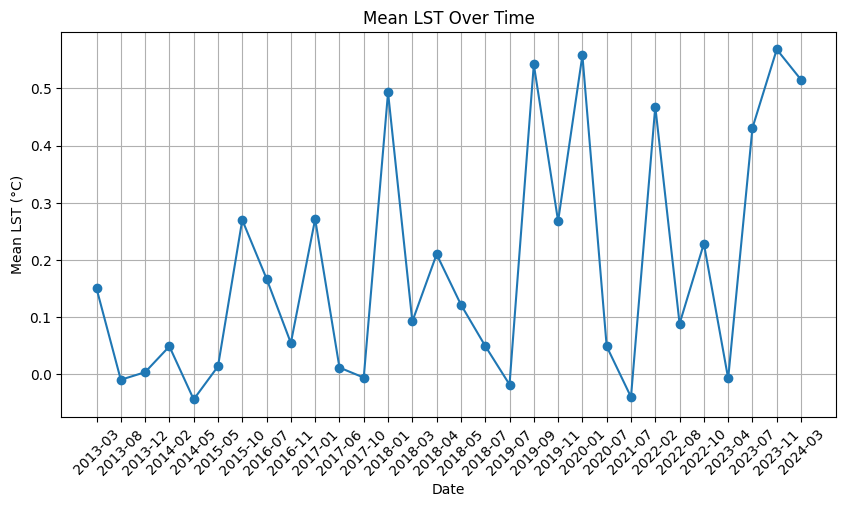

['2013-09', '2016-07', '2017-11', '2018-01', '2019-05', '2019-09', '2020-06', '2021-05', '2023-06']


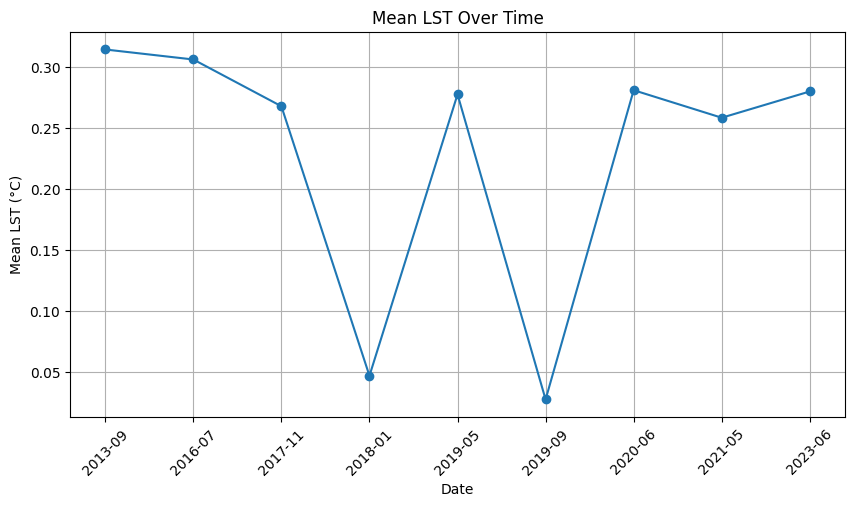

['2013-08', '2014-05', '2014-09', '2014-11', '2015-07', '2015-10', '2016-01', '2016-02', '2016-04', '2016-06', '2016-08', '2016-10', '2016-11', '2017-02', '2017-06', '2017-09', '2017-10', '2017-12', '2018-02', '2018-09', '2020-01', '2020-02', '2020-07', '2020-10', '2020-11', '2021-03', '2021-04', '2021-10', '2021-12', '2022-01', '2022-02', '2022-05', '2022-06', '2022-07', '2022-09', '2023-01', '2023-07', '2023-09', '2024-04', '2024-06', '2024-07']


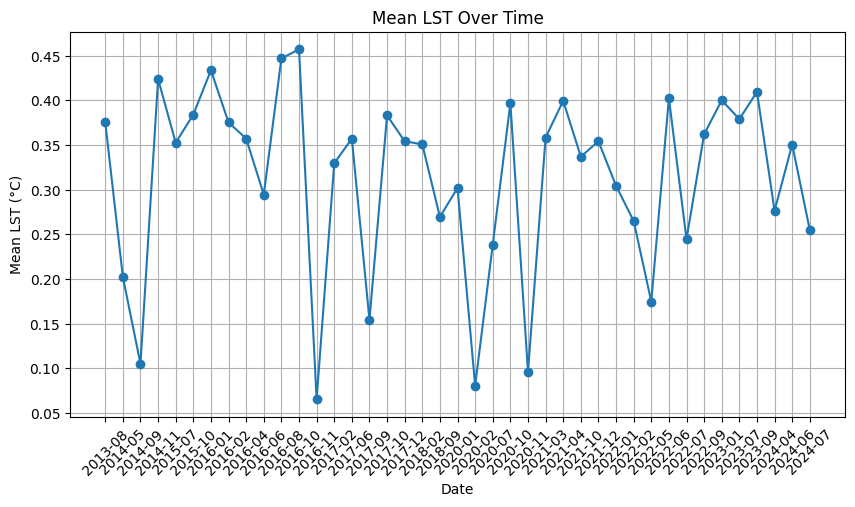

['2014-03', '2014-08', '2015-10', '2016-06', '2016-12', '2017-05', '2017-12', '2018-07', '2019-01', '2019-06', '2019-11', '2020-03', '2021-02', '2021-08', '2022-09', '2022-10', '2023-01', '2024-07', '2024-08']


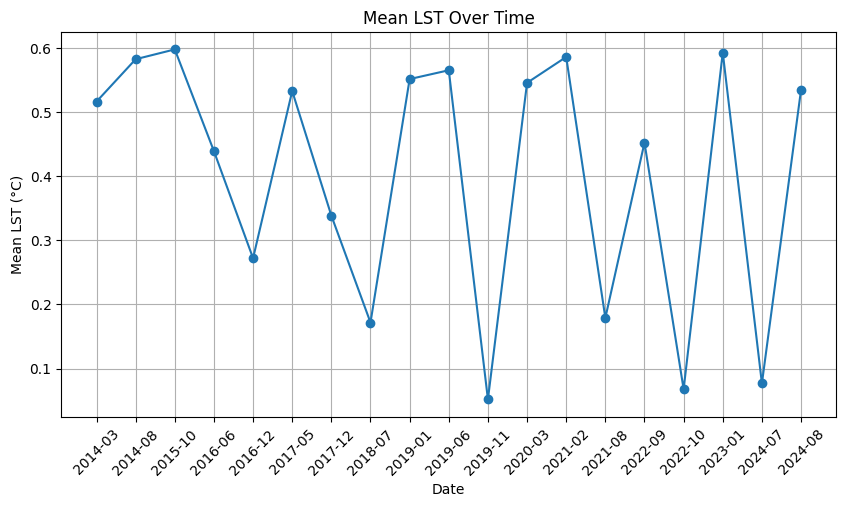

['2013-04', '2013-09', '2015-02', '2015-04', '2015-05', '2015-06', '2016-01', '2016-04', '2017-01', '2017-02', '2017-04', '2017-10', '2020-02', '2020-12', '2021-01', '2021-12', '2022-05', '2022-08', '2022-09', '2023-09', '2024-08']


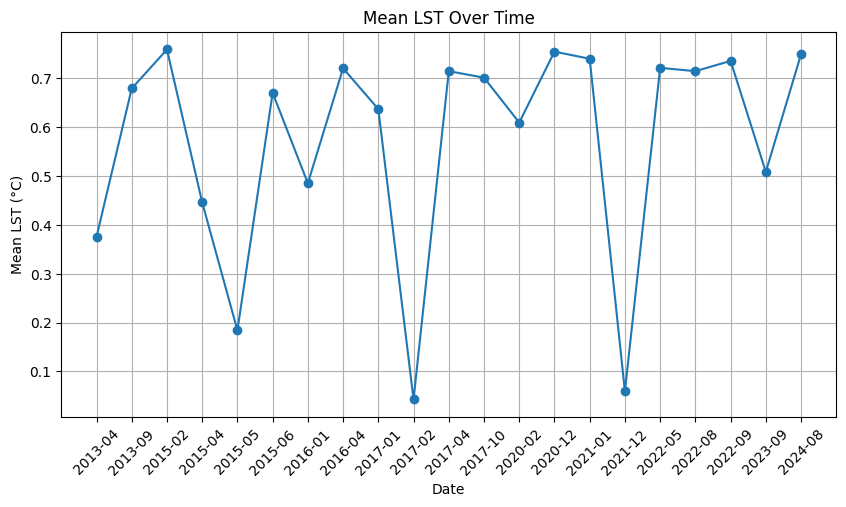

['2013-09', '2013-12', '2017-05', '2019-10', '2021-09', '2022-07', '2023-05']


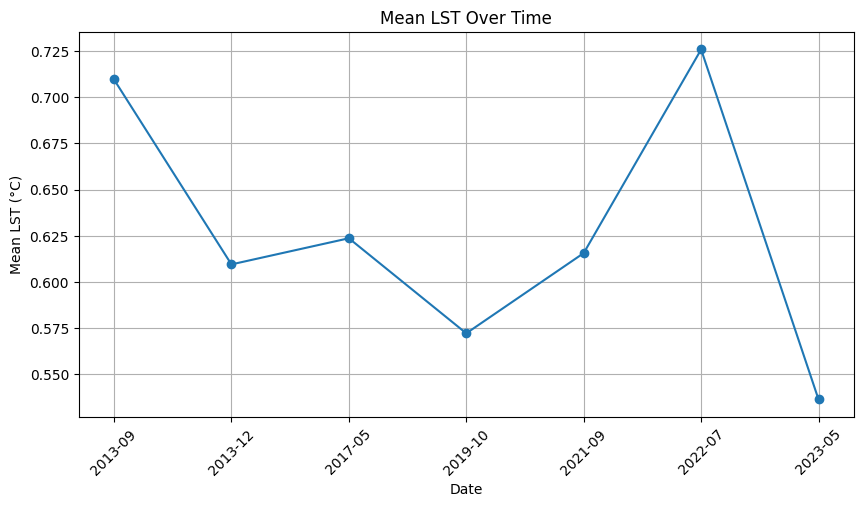

['2013-04', '2014-06', '2014-10', '2015-04', '2015-05', '2016-02', '2016-05', '2016-06', '2019-02', '2019-06', '2019-09', '2022-10', '2022-12']


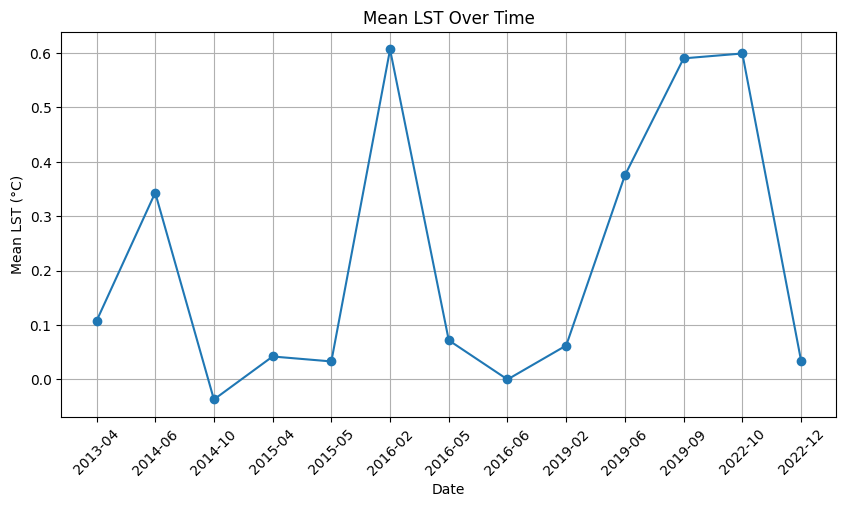

['2013-07', '2014-10', '2015-04', '2015-05', '2015-07', '2015-08', '2016-08', '2017-01', '2017-04', '2017-09', '2017-11', '2018-02', '2018-03', '2019-07', '2019-10', '2019-12', '2021-11', '2022-08', '2022-09', '2023-03', '2023-07', '2023-10', '2023-12', '2024-01', '2024-04', '2024-07']


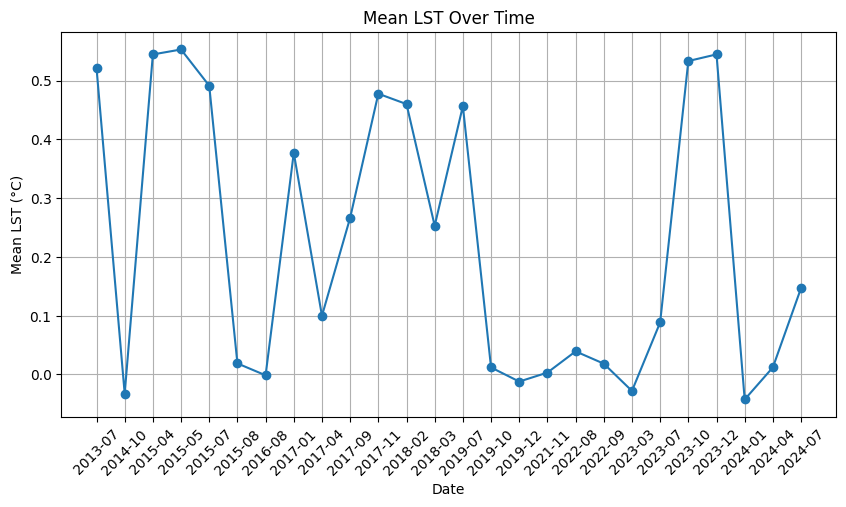

['2013-03', '2013-05', '2013-09', '2014-01', '2014-03', '2016-06', '2016-10', '2017-02', '2017-10', '2018-03', '2018-04', '2018-05', '2018-06', '2018-11', '2019-02', '2019-05', '2019-09', '2019-10', '2020-01', '2020-03', '2020-10', '2020-12', '2021-06', '2021-09', '2022-01', '2022-05', '2022-06', '2023-04', '2023-05', '2023-07', '2023-08', '2024-02', '2024-03', '2024-06', '2024-08']


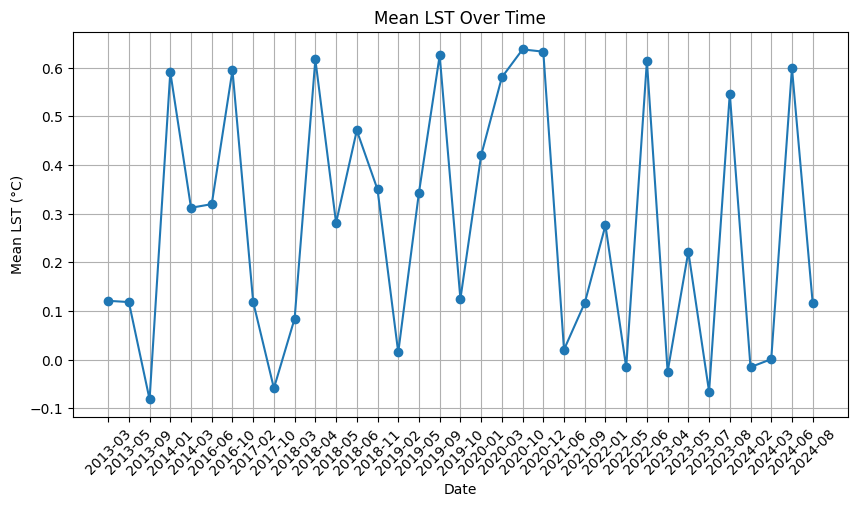

['2014-12', '2015-02', '2015-04', '2015-06', '2015-10', '2018-11', '2019-11', '2020-09', '2020-12', '2021-02', '2021-12', '2022-04', '2022-06', '2022-08', '2022-09', '2023-02', '2024-02', '2024-07']


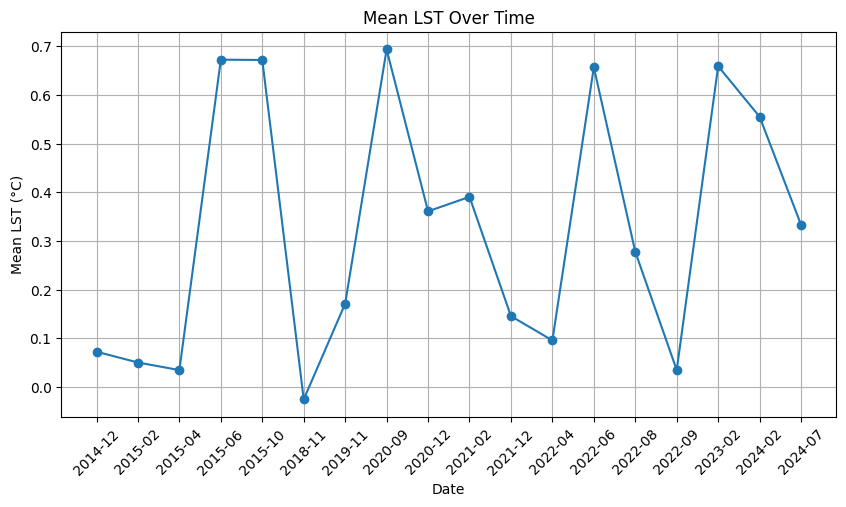

['2014-12', '2015-05', '2015-11', '2017-06', '2021-04', '2021-05', '2021-12', '2024-09']


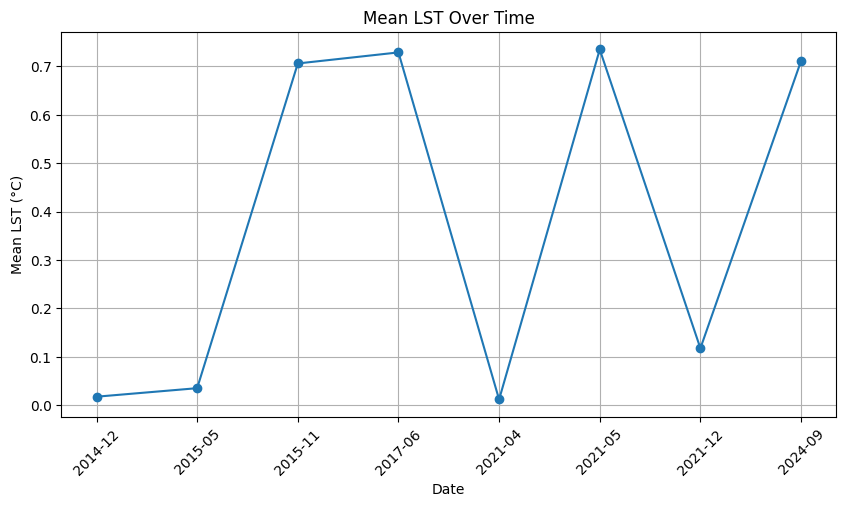

In [44]:

for i,(k, imgs) in enumerate(data.items()):
    dates = []
    mean_lst_values = []
    if len(imgs)>0:
        for j,img in enumerate(imgs):
            date = times[i][j]
            dates.append(date)
            
            mean_lst = np.mean(img)
            mean_lst_values.append(mean_lst)
        print(dates)
        sorted_dates, sorted_means = zip(*sorted(zip(dates, mean_lst_values)))
    
        # Plot the mean LST over time
        plt.figure(figsize=(10, 5))
        plt.plot(sorted_dates, sorted_means, marker='o')
        plt.xlabel("Date")
        plt.ylabel("Mean LST (°C)")
        plt.title("Mean LST Over Time")
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()
    